In [24]:
# ANALYLZE
import os
import json
import torch
import pickle
import warnings
import _jsonnet
import numpy as np
import matplotlib.pyplot as plt

import itertools 
import transformers
import seaborn as sns
import networkx as nx

from ratsql.commands.infer import Inferer
from ratsql.utils.analysis import cal_attention_flow
from search import read_data, match, show_results
from run_all import test_example, load_model, TestInfo
from ratsql.utils.relation_names import RELATION_NAMES

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="5"

In [25]:
## for attention flow
def draw_attention_graph(adjmat, labels_to_index, n_layers, length):
    A = adjmat
    G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(G, {(i,j): A[i,j]}, 'capacity')

    pos = {}
    label_pos = {}
    for i in np.arange(n_layers+1):
        for k_f in np.arange(length):
            pos[i*length+k_f] = ((i+0.5)*2, length - k_f)
            label_pos[i*length+k_f] = (i*2, length - k_f)

    index_to_labels = {}
    for key in labels_to_index:
        index_to_labels[labels_to_index[key]] = key.split("_")[-1]
        if labels_to_index[key] >= length:
            index_to_labels[labels_to_index[key]] = ''

    #plt.figure(1,figsize=(20,12))

    nx.draw_networkx_nodes(G,pos,node_color='green', node_size=50)
    nx.draw_networkx_labels(G,pos=label_pos, labels=index_to_labels, font_size=10)

    all_weights = []
    #4 a. Iterate through the graph nodes to gather all the weights
    for (node1,node2,data) in G.edges(data=True):
        all_weights.append(data['weight']) #we'll use this when determining edge thickness

    #4 b. Get unique weights
    unique_weights = list(set(all_weights))

    #4 c. Plot the edges - one by one!
    for weight in unique_weights:
        #4 d. Form a filtered list with just the weight you want to draw
        weighted_edges = [(node1,node2) for (node1,node2,edge_attr) in G.edges(data=True) if edge_attr['weight']==weight]
        #4 e. I think multiplying by [num_nodes/sum(all_weights)] makes the graphs edges look cleaner
        
        w = weight #(weight - min(all_weights))/(max(all_weights) - min(all_weights))
        width = w
        nx.draw_networkx_edges(G,pos,edgelist=weighted_edges,width=width, edge_color='darkblue')
    
    return G

def get_adjmat(mat, input_tokens):
    n_layers, length, _ = mat.shape
    adj_mat = np.zeros(((n_layers+1)*length, (n_layers+1)*length))
    labels_to_index = {}
    for k in np.arange(length):
        labels_to_index[str(k)+"_"+input_tokens[k]] = k

    for i in np.arange(1,n_layers+1):
        for k_f in np.arange(length):
            index_from = (i)*length+k_f
            label = "L"+str(i)+"_"+str(k_f)
            labels_to_index[label] = index_from
            for k_t in np.arange(length):
                index_to = (i-1)*length+k_t
                adj_mat[index_from][index_to] = mat[i-1][k_f][k_t]
                
    return adj_mat, labels_to_index 

def add_residual_connection(attentions_mat):
    """
    attentions_mat: (layer_num, head_num, seq_len, seq_len)
    """
    res_att_mat = attentions_mat.sum(axis=1)/attentions_mat.shape[1]
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]
    return res_att_mat

def compute_flows(G, labels_to_index, input_nodes, length):
    print(type(G))
    print(type(labels_to_index))
    print(type(input_nodes))
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in labels_to_index:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v, flow_func=nx.algorithms.flow.edmonds_karp)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def convert_adjmat_tomats(adjmat, n_layers, l):
    mats = np.zeros((n_layers,l,l))
    for i in np.arange(n_layers):
        mats[i] = adjmat[(i+1)*l:(i+2)*l,i*l:(i+1)*l]
    return mats

def plot_attention_heatmap(att, s_position, t_positions, sentence):
    
  print(att[:,s_position, t_positions].shape)
  for idx, values in enumerate(att[:,s_position, t_positions]):
      print(f"idx:{idx} values:{values}")
  cls_att = np.flip(att[:,s_position, t_positions], axis=0)
  xticklb = input_tokens= list(itertools.compress(['<cls>']+sentence.split(), [i in t_positions for i in np.arange(len(sentence)+1)]))
  yticklb = [str(i) if i%2 ==0 else '' for i in np.arange(att.shape[0],0, -1)]
  ax = sns.heatmap(cls_att, xticklabels=xticklb, yticklabels=yticklb, cmap="YlOrRd")
  return ax

def get_attention_flow(tokens, attentions_mat):
    """
    attentions_mat: (layer_num, head_num, seq_len, seq_len)
    """
    layer_num, head_num, seq_len, seq_len = attentions_mat.shape
    res_att_mat = add_residual_connection(attentions_mat)
    
    # Convert matrices to adjacency matrices
    res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=tokens)

    #@title plot the attention graph
    plt.figure(figsize=(20,10))

    # res_adj_mat and res_labels_to_index are the results of get_adjmat()
    res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=layer_num, length=seq_len)

    # Calculate the flow values
    input_nodes = []
    for key in res_labels_to_index:
        if res_labels_to_index[key] < seq_len:
            input_nodes.append(key)
    flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=seq_len)
    
    # Convert adjacency matrix to matrices
    flow_att_mat = convert_adjmat_tomats(flow_values, n_layers=layer_num, l=seq_len)

    return flow_att_mat

def draw_attention_flow(sentence, target_idx, flow_att_mat, indices_to_inspect=None):
    # Select source indices to inspect
    if indices_to_inspect is None:
        indices_to_inspect = list(range(sentence))
    
    # Plot the attention flow
    plt.figure(1,figsize=(3,6))
    plot_attention_heatmap(flow_att_mat, target_idx, t_positions=indices_to_inspect, sentence=sentence)


In [26]:
# Paths
project_dir = "/home/hkkang/NL2QGM"

# Trained model seeds
model_seeds = [0, 2, 3]

def get_info_paths(model_type, target_model_seed):
    bert_template = "logdir/spider_bert_run_no_join_cond_seed_{}/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed={},join_cond=false/ie_dirs/bert_run_true_1-step_41600-eval.json"
    electra_template = "logdir/spider_electra_run_no_join_cond_seed_{}/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed={},join_cond=false/ie_dirs/electra_run_true_1-step_41600-eval.json"
    template = bert_template if model_type == 'bert' else electra_template
    template = os.path.join(project_dir, template)

    if model_type == 'electra':
        if target_model_seed == 0:
            template = template.replace('41600', '18000')
        elif target_model_seed == 2:
            template = template.replace('41600', '25000')
        elif target_model_seed == 3:
            template = template.replace('41600', '26000')
    elif model_type == 'bert':
        if target_model_seed == 0:
            template = template.replace('41600', '78000')

    eval_paths = []
    for seed in model_seeds:
        eval_paths += [template.format(seed, seed)]

    infer_paths = [path.replace("-eval.json", "-infer.jsonl") for path in eval_paths]
    debug_paths = [path.replace("-eval.json", "-debug.jsonl") for path in eval_paths]
    return infer_paths, debug_paths, eval_paths

In [27]:
# Load tables.json
tables_path = os.path.join(project_dir, "data/spider/tables.json")

with open(tables_path) as f:
    dbs = {item['db_id']: item for item in json.load(f)}

def get_column_names(db_id):
    db = dbs[db_id]
    tables = db['table_names']
    columns = []
    for table_id, column_name in db['column_names']:
        column_name = column_name.replace(' ', '_')
        if table_id == -1:
            columns.append(column_name)
        else:
            columns.append(f"{tables[table_id].replace(' ', '_')}.{column_name}")
    return columns

def get_table_names(db_id):
    db = dbs[db_id]
    tables = db['table_names']
    return [table.replace(' ', '_') for table in tables]

In [28]:
# Helper functions

def load_json_custom(path):
    result = json.load(open(path))['per_item']
    return result

def load_jsonl(path):
    with open(path, 'r') as f:
        results = [json.loads(line) for line in f.readlines()]
    return results

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_info(eval_path, debug_path, infer_path):
    eval_result = load_json_custom(eval_path.replace('.json', '-testing.json'))[0]
    debug_cache = load_pickle(debug_path.replace('.jsonl', '-testing.pkl'))[0]
    debug_result = load_jsonl(debug_path.replace('.jsonl', '-testing.jsonl'))[0]
    infer_result = load_jsonl(infer_path.replace('.jsonl', '-testing.jsonl'))[0]

    return eval_result, debug_result, debug_cache, infer_result

In [43]:
def visualize_attention(mma, target_labels, source_labels, title=None, decimal=4, save_as_file=False):
    """
    Inputs:
        mma: nxn weight matrix
        source_labels: List of column labels
        target_labels: List of row labels
    """
    fig, ax = plt.subplots(figsize=(20,20), dpi=100)
    im = ax.imshow(mma)
    
    # put the major ticks at the middle of each cell
    ax.set_xticks(np.arange(mma.shape[1]), minor=False) # mma.shape[1] = target seq 길이
    ax.set_yticks(np.arange(mma.shape[0]), minor=False) # mma.shape[0] = input seq 길이
   
    # source words -> column labels
    ax.set_xticklabels(source_labels, minor=False)
    # target words -> row labels
    ax.set_yticklabels(target_labels, minor=False)
  
    # want a more natural, table-like display
    ax.invert_yaxis()
    ax.xaxis.tick_top()
 
    plt.xticks(rotation=65)
 
    if title:
        ax.set_title(title)

    # Loop over data dimensions and create text annotations.
    for i in range(len(mma)):
        for j in range(len(mma[0])):
            if decimal == 4:
                text = ax.text(j, i, "{:.4f}".format(mma[i, j].item()), ha="center", va="center", color="k")
            else:
                text = ax.text(j, i, "{:.3f}".format(mma[i, j].item()), ha="center", va="center", color="k")
        
    plt.tight_layout()
    if save_as_file:
        plt.savefig(f'{title}.png', dpi=100)
    else:
        plt.show()

In [30]:
def show_schema_entity_indices(eval_result, debug_result, debug_cache, infer_result):
    db_id = eval_result['db_id']
    questions = debug_cache['question']
    input_columns = debug_cache['columns']
    input_tables = debug_cache['tables']
    columns = get_column_names(db_id)
    tables = get_table_names(db_id)
    assert len(columns) == len(input_columns), f"{len(columns)} vs {len(input_columns)}"
    assert len(tables) == len(input_tables), f"{len(tables)} vs {len(input_tables)}"
    tokens = questions + columns + tables
    for idx, token in enumerate(tokens):
        if idx < len(questions):
            continue
        if idx < (len(questions) + len(columns)):
            entity_type = 'column'
        else:
            entity_type = 'table'
        print(f"idx:{idx}\t{entity_type}:\t{token}")
        
def get_vector_norm(vector):
    try:
        return np.linalg.norm(vector)
    except:
        return torch.linalg.norm(vector)
    
def show_basic_details(eval_result, debug_result, debug_cache, infer_result):
    db_id = eval_result['db_id']
    nl = infer_result['question_toks']
    pred = eval_result['predicted']
    gold = eval_result['gold']
    decode_history = debug_result['history']
    correct = eval_result['exact']
    print(f"Is_correct:{bool(correct)}")
    print(f"DB_id:{db_id}")
    print(f"NL:{nl}")
    print(f"Pred:{pred}")
    print(f"Gold:{gold}\n")  

In [55]:
def show_encoder_details(eval_result, debug_result, debug_cache, infer_result, src_idx, des_idx, inspect_layer_num, target_key, top_k=10, prefix=None):
    def get_layer_idx(key):
        if 'layer' in key:
            return int(key.split('_')[1])
        return None
        
    def to_str(value):
        if type(value) == str:
            return value
        elif type(value) == list:
            return ' '.join(value)
        else:
            raise RuntimeError(f"Bad type:{value}")

    def print_top_7(joint_weight_matrix, input_tokens):
        """
        joint_weight_matrix: [input_num, output_num]
        """
        top_7_values, top_7_indices = torch.topk(joint_weight_matrix, k=7)
        for cur_idx, (top_7_index, top_7_value) in enumerate(zip(top_7_indices, top_7_values)):
            print(f"idx:{cur_idx} word:{input_tokens[cur_idx]}")
            for top_idx, (item_idx, weight_value) in enumerate(zip(top_7_index, top_7_value)):
                print(f"\ttop{top_idx+1}_idx:{item_idx} (word:{input_tokens[item_idx]}) {weight_value}")

    def print_top_7_for_all_layer_for_target_word(joint_weight_matrix, input_tokens, target_word_idx):
        """
        joint_weight_matrix: [layer_num, input_num, output_num]
        """
        joint_weight_matrix = torch.tensor(joint_weight_matrix)[:,target_word_idx,:]
        print(joint_weight_matrix.shape)
        top_7_values, top_7_indices = torch.topk(joint_weight_matrix, k=7)
        for cur_idx, (top_7_index, top_7_value) in enumerate(zip(top_7_indices, top_7_values)):
            print(f"idx:{cur_idx} word:{input_tokens[target_word_idx]}")
            for top_idx, (item_idx, weight_value) in enumerate(zip(top_7_index, top_7_value)):
                print(item_idx)
                print(f"\ttop{top_idx+1}_idx:{item_idx} (word:{input_tokens[item_idx]}) {weight_value}")

                
    def print_float(prefix, tensor):
        assert len(tensor.shape) == 1, f"bad: {tensor.shape}"
        print(prefix)
        print(f'\t', end='')
        avg = sum(tensor) / len(tensor)
        print("{:.3f}  |\t".format(avg), end='')
        for value in tensor:
            print("{:.3f}\t".format(value), end='')
        print("")

    def show_attention_infos(debug_cache, tokens, inspect_layer_num, src_idx, des_idx):
        # Show \alpha_{ij}, e_{ij}, embedding_sim, relation_bias_sim
        attn_probs =  debug_cache[f'layer_{inspect_layer_num}_attn_probs']
        sim_logits =  debug_cache[f'layer_{inspect_layer_num}_sim_logits']
        word_sim = debug_cache[f'layer_{inspect_layer_num}_emb_sim_logits']
        bias_sim = debug_cache[f'layer_{inspect_layer_num}_bias_sim_logits']
        relation_id = debug_cache['relation'][src_idx][des_idx]
        relation_name = RELATION_NAMES[relation_id]
        print(f"layer_num:{inspect_layer_num}")
        print(f"i:{src_idx} ({tokens[src_idx]}) j:{des_idx} ({tokens[des_idx]}) r:{relation_id} ({relation_name})")
        print_float("softmax_prob:", attn_probs[:, src_idx, des_idx])
        print_float("sim_score (word+bias):", sim_logits[:, src_idx, des_idx])
        print_float("word_sim:", word_sim[:, src_idx, des_idx])
        print_float("bias_sim:", bias_sim[:, src_idx, des_idx])
        print_float("word_sim_prob:", torch.softmax(torch.tensor(word_sim), dim=-1)[:, src_idx, des_idx])
        print_float("bias_sim_prob:", torch.softmax(torch.tensor(bias_sim), dim=-1)[:, src_idx, des_idx])
        print("")

    def show_top_attention_infos_for_layer(target_inspect_layer_num, debug_cache, tokens, inspect_layer_num, src_idx, des_idx):
        attn_probs = torch.tensor(debug_cache[f'layer_{target_inspect_layer_num}_attn_probs'])
        avg_attn_probs = attn_probs.mean(dim=0)
        if des_idx is None:
            if top_k:
                # Find top-10 most similary des_indices
                top_values, top_indices = torch.topk(avg_attn_probs[src_idx], k=min(top_k, len(avg_attn_probs)))
                des_indices = top_indices
                # Show attention info for all target destination indices
                for top_idx, target_des_idx in enumerate(des_indices):
                    print(f"Top {top_idx+1}")
                    show_attention_infos(debug_cache, tokens, target_inspect_layer_num, src_idx, target_des_idx)
            else:
                for target_des_idx in range(len(tokens)):
                    show_attention_infos(debug_cache, tokens, target_inspect_layer_num, src_idx, target_des_idx)
                    
        else:
            # Find information for des_idx
            top_values, top_indices = torch.topk(avg_attn_probs[src_dix], k=len(attn_probs))
            # top_idx = ((top_indices == des_idx).nonzero(as_tuple=True)[0])
            top_idx = top_indices.cpu().numpy().tolist().index(des_idx)
            print(f"Top {top_idx+1}")
            show_attention_infos(debug_cache, tokens, target_inspect_layer_num, src_idx, des_idx)

    show_basic_details(eval_result, debug_result, debug_cache, infer_result)
    db_id = eval_result['db_id']
    pred = eval_result['predicted']
    gold = eval_result['gold']
    decode_history = debug_result['history']
    correct = eval_result['exact']
    questions = debug_cache['question']
    input_columns = debug_cache['columns']
    input_tables = debug_cache['tables']
    columns = get_column_names(db_id)
    tables = get_table_names(db_id)
    assert len(columns) == len(input_columns), f"{len(columns)} vs {len(input_columns)}"
    assert len(tables) == len(input_tables), f"{len(tables)} vs {len(input_tables)}"
    tokens = questions + columns + tables
    tokens_len = len(tokens)
    # Attention flow
    if target_key == "attention_score":
        # Select target destination indices
        if inspect_layer_num is None:
            for target_inspect_layer_num in range(8):
                show_top_attention_infos_for_layer(target_inspect_layer_num,
                                                   debug_cache, tokens, target_inspect_layer_num, src_idx, des_idx)
        else:
            target_inspect_layer_num = inspect_layer_num
            show_top_attention_infos_for_layer(target_inspect_layer_num,
                                    debug_cache, tokens, target_inspect_layer_num, src_idx, des_idx)

    elif target_key == 'draw_attention_prob':
        # Draw input x input matrix
        for target_inspect_layer_num in range(8):
            attn_probs = torch.tensor(debug_cache[f'layer_{target_inspect_layer_num}_attn_probs'])
            avg_attn_probs = attn_probs.sum(dim=0)
            x = tokens
            y = tokens
            visualize_attention(avg_attn_probs, x, y, title=f'{prefix}_token-token_attention_prob_layer-{target_inspect_layer_num}', decimal=3, save_as_file=True)
            
    elif target_key == 'draw_word_embeddings':
        # Draw input x input matrix
        for target_inspect_layer_num in range(8):
            word_sim = debug_cache[f'layer_{target_inspect_layer_num}_emb_sim_logits']
            word_sim_prob = torch.softmax(torch.tensor(word_sim), dim=-1).squeeze(0)
            avg_word_sim_prob = word_sim_prob.sum(dim=0)
            x = tokens
            y = tokens
            visualize_attention(avg_word_sim_prob, x, y, title=f'{prefix}_token-token_word_prob_layer-{target_inspect_layer_num}', decimal=3, save_as_file=True)
        
    elif target_key == 'draw_relation_embeddings':
        avg_bias_sim_probs = []
        for target_inspect_layer_num in range(8):
            ## 1. Draw input x input
            ### 1.1 Create attention matrix: input x input
            bias_sim = debug_cache[f'layer_{target_inspect_layer_num}_bias_sim_logits']
            bias_sim_prob = torch.softmax(torch.tensor(bias_sim), dim=-1).squeeze(0)
            avg_bias_sim_prob = bias_sim_prob.sum(dim=0)
            avg_bias_sim_probs.append(avg_bias_sim_prob)
        
            ## 2. Draw input x relation
            ### 2.1 Create attention matrix: input x relation
            attention_matrix = torch.zeros(avg_bias_sim_prob.shape[0], len(RELATION_NAMES))
            history = []
            for src_idx in range(avg_bias_sim_prob.shape[0]):
                for target_des_idx in range(bias_sim_prob.shape[-1]):
                    relation_id = debug_cache['relation'][src_idx][target_des_idx]
                    relation_name = RELATION_NAMES[relation_id]
                    if relation_id not in history:
                        history.append(relation_id)
                    attention_matrix[src_idx][relation_id] = avg_bias_sim_prob[src_idx][target_des_idx]
            
            # Filter out unused relations
            history = sorted(list(set(history)))
            filtered_relation_names = [RELATION_NAMES[i] for i in history]
            filtered_attention_matrix = torch.zeros(avg_bias_sim_prob.shape[0], len(history))
            for source_idx in range(avg_bias_sim_prob.shape[0]):
                for relation_id in debug_cache['relation'][source_idx]:
                    idx = history.index(relation_id)
                    filtered_attention_matrix[source_idx, idx] = attention_matrix[source_idx, relation_id]
            
            ### 2.2 Draw attention matrix
            x = tokens
            y = filtered_relation_names
            visualize_attention(filtered_attention_matrix, x, y, title=f'{prefix}_token-relation_bias_prob_layer-{target_inspect_layer_num}', decimal=3, save_as_file=True)
        
        # Draw attention matrix
        for layer_num, avg_bias_sim_prob in enumerate(avg_bias_sim_probs):
            x = tokens
            y = tokens
            visualize_attention(avg_bias_sim_prob, x, y, title=f'{prefix}_token-token_bias_prob_layer-{layer_num}', decimal=3, save_as_file=True)
        

            
    elif target_key == 'relation_embeddings':
        # Get all relation ids used in src_idx
        relation_ids = list(set(debug_cache['relation'][src_idx]))
        
        for inspect_layer_num in range(8):
            attn_probs =  debug_cache[f'layer_{inspect_layer_num}_attn_probs']
            sim_logits =  debug_cache[f'layer_{inspect_layer_num}_sim_logits']
            word_sim = debug_cache[f'layer_{inspect_layer_num}_emb_sim_logits']
            bias_sim = debug_cache[f'layer_{inspect_layer_num}_bias_sim_logits']
            print(f"layer_num:{inspect_layer_num}")
            bias_sim_prob = torch.softmax(torch.tensor(bias_sim), dim=-1).squeeze(0)[:, src_idx].data.cpu().numpy()

            history = []
            for target_des_idx in range(bias_sim_prob.shape[-1]):
                relation_id = debug_cache['relation'][src_idx][target_des_idx]
                relation_name = RELATION_NAMES[relation_id]
                cnt_relation_id = np.count_nonzero(debug_cache['relation'][src_idx] == relation_id)
                if relation_id not in history:
                    history.append(relation_id)
                    avg_prob = sum(bias_sim_prob[:, target_des_idx]) / bias_sim_prob.shape[0]
                    print(f"\trelation_id: {relation_id} ({relation_name}) x {cnt_relation_id}")
                    print('\t\t\t\t{:.3f} |\t'.format(avg_prob), end='')
                    
                    for value in bias_sim_prob[:, target_des_idx]:
                        print("{:.3f}\t".format(value), end='')
                    print('')

    elif target_key  == 'relation_embeddings':
        assert inspect_layer_num is not None, "Inspect_layer_num should not be None"
        for key, value in debug_cache.items():
            if inspect_layer_num == get_layer_idx(key):
                if 'relation_k_embs' in key or 'relation_v_embs' in key:
                    print(key)
                    for relation_id, relation_emb in enumerate(value):
                        print(f"Relation: {relation_id} ({RELATION_NAMES[relation_id]}) scale: {get_vector_norm(relation_emb)}")
                    print('')

    elif target_key in ['attention_flow']:
        bert_attention = torch.stack(debug_cache['bert_attention']).squeeze(1)
        bert_attention = bert_attention[:3]
        bert_tokens = debug_cache['input_tokens']
        flow_att_mat = get_attention_flow(bert_tokens, bert_attention)
        sentence = ' '.join(bert_tokens[1:-1])
        draw_attention_flow(sentence, 3, flow_att_mat, [10, 14])

    elif target_key in ['semi_attention_flow']:
        bert_attention = torch.stack(debug_cache['bert_attention']).squeeze(1)
        bert_tokens = debug_cache['input_tokens']
        joint_weight_matrix = cal_attention_flow(bert_attention)
        ## Create label
        # target_labels = list(map(to_str, bert_input))
        # source_labels = target_labels
        # visualize_attention(joint_weight_matrix, source_labels, target_labels, title='Bert attention flow')
        
        # Show top 10 words instead of visualization
        # Top 7 index and value from weights tensor
        # print_top_7(joint_weight_matrix, bert_input)
        print_top_7_for_all_layer_for_target_word(bert_attention.sum(dim=1)/bert_attention.shape[1], bert_tokens, 3)

    # More detail attention
    else:
        for key, value in debug_cache.items():
            layer_idx = get_layer_idx(key)

            # only show desired key
            if "_".join(key.split('_')[2:]) != target_key:
                continue

            tmps = []
            for tmp_des_idx in range(tokens_len):
                if 'sim_logits' in key:
                    target_value = value[src_idx][tmp_des_idx]
                elif 'attn_probs' in key:
                    target_value = value[src_idx][tmp_des_idx]
                elif 'emb_sim_logits' in key:
                    target_value = value[src_idx][tmp_des_idx]
                elif 'bias_sim_logits' in key:
                    target_value = value[src_idx][tmp_des_idx]
                elif 'relation_k_embs' in key:
                    relation_idx = debug_cache[f'layer_{layer_idx}_relation'][src_idx][tmp_des_idx]
                    target_value = get_vector_norm(value[relation_idx])
                elif 'relation_v_embs' in key:
                    relation_idx = debug_cache[f'layer_{layer_idx}_relation'][src_idx][tmp_des_idx]
                    target_value = get_vector_norm(value[relation_idx])

                print(f"key:{key} src:{src_idx} ({tokens[src_idx]}) -> des:{tmp_des_idx} ({tokens[tmp_des_idx]}) value:{target_value}")
                tmps.append(np.expand_dims(target_value, axis=0))

            # Draw attention
            target_labels = list(map(to_str, [tokens[src_idx]]))
            source_labels = list(map(to_str, tokens))
            tmps = np.stack(tmps)
            visualize_attention(np.stack(tmps), source_labels, target_labels, title=key)
    
    # Scale
    
    #
    pass

In [52]:
# show results
def show_decoder_details(eval_result, debug_result, debug_cache, infer_result, inspect_step_idx=None):
    show_basic_details(eval_result, debug_result, debug_cache, infer_result)
    db_id = eval_result['db_id']
    decode_history = debug_result['history']
    input_columns = debug_cache['columns']
    input_tables = debug_cache['tables']
    columns = get_column_names(db_id)
    tables = get_table_names(db_id)
    assert len(columns) == len(input_columns), f"{len(columns)} vs {len(input_columns)}"
    assert len(tables) == len(input_tables), f"{len(tables)} vs {len(input_tables)}"
    
    if inspect_step_idx is None:
        # Show all steps briefly
        for step, step_info in enumerate(decode_history):
            print(f"Step: {step}")
            rule_left = step_info['rule_left']
            choices = step_info['choices']
            probs = step_info['probs']

            # Decoder: action choices and probs
            print(f"rule_left: {rule_left}")
            print(f"choices: {choices}")
            print(f"probs: {['{:.2f}'.format(prob*100) for prob in probs]}\n")
        return None
    else:
        # Analyze decoding steps
        for step, step_info in enumerate(decode_history):
            if inspect_step_idx != None and inspect_step_idx != step:
                continue

            # For easy referencing
            db_id = infer_result['db_id']
            nl_toks = infer_result['question_toks']
            ## Schema and memory
            tables = [' '.join(item) for item in infer_result['schema']['tables']]
            columns_no_table = [' '.join(item[:-1]) for item in infer_result['schema']['columns']]
            memory = nl_toks+columns+tables
            ## align_mat
            mc_align_matrix = torch.tensor(debug_cache['m2c_align_mat'])
            mt_align_matrix = torch.tensor(debug_cache['m2t_align_mat'])
            ## action scores
            decode_history = debug_result['history']
            ## encoder attention weight for each layers

            print(f"Step: {step}")
            # For easy reference
            rule_left = step_info['rule_left']
            choices = step_info['choices']
            probs = step_info['probs']

            # Decoder: action choices and probs
            print(f"rule_left: {rule_left}")
            print(f"choices: {choices}")
            print(f"probs: {['{:.2f}'.format(prob*100) for prob in probs]}")

            # Decoder: hidden state - memory attention
            dec_att = torch.tensor(step_info['att_probs'])
            visualize_attention(dec_att.transpose(0,1), memory, ['hidden_state'],
                                    title="Hidden state - Memory attention")

            # More info for column/table
            if rule_left in ['column', 'table']:
                    # Analyze align matrix
                if rule_left == 'column':
                    visualize_attention(mc_align_matrix, memory, columns_no_table, title="Memory - Column alignment", decimal=3)
                else:
                    visualize_attention(mt_align_matrix, memory, tables, title="Memory - Table alignment", decimal=3)
                
                # Decoder: memory-pointer probs
                memory_pointer_probs = torch.tensor(step_info['memory_pointer_probs'])
                visualize_attention(memory_pointer_probs.transpose(0, 1), 
                                    memory, ['hidden_state'], title='Memory pointer probs')

In [33]:
# Load model
warnings.filterwarnings('ignore')
trained_bert_models = [load_model(seed, model_type='bert') for seed in model_seeds]
trained_electra_models = [load_model(seed, model_type='electra') for seed in model_seeds]

WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'bert-large-uncased-whole-word-masking-finetuned-squad', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink'}}


Loading model from logdir/spider_bert_run_no_join_cond_seed_0/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=0,join_cond=false/model_checkpoint-078000.pt
loaded model has last_step:78000


WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'bert-large-uncased-whole-word-masking-finetuned-squad', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink'}}


Loading model from logdir/spider_bert_run_no_join_cond_seed_2/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=2,join_cond=false/best_model.pt
loaded model has last_step:41600


WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'bert-large-uncased-whole-word-masking-finetuned-squad', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=bertsquad,cvlink'}}


Loading model from logdir/spider_bert_run_no_join_cond_seed_3/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=3,join_cond=false/best_model.pt
loaded model has last_step:41600


WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'ahotrod/electra_large_discriminator_squad2_512', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink'}}


Loading model from logdir/spider_electra_run_no_join_cond_seed_0/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=0,join_cond=false/model_checkpoint-018000.pt
loaded model has last_step:18000


WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'ahotrod/electra_large_discriminator_squad2_512', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink'}}


Loading model from logdir/spider_electra_run_no_join_cond_seed_2/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=2,join_cond=false/model_checkpoint-025000.pt
loaded model has last_step:25000


WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
WARNING <class 'ratsql.models.enc_dec.EncDecModel'>: superfluous {'decoder_preproc': {'grammar': {'clause_order': None, 'end_with_from': True, 'factorize_sketch': 2, 'include_literals': False, 'infer_from_conditions': False, 'name': 'spider', 'output_from': True, 'use_table_pointer': True}, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink', 'use_seq_elem_rules': True}, 'encoder_preproc': {'bert_version': 'ahotrod/electra_large_discriminator_squad2_512', 'compute_cv_link': True, 'compute_sc_link': True, 'db_path': 'data/spider_test/database', 'fix_issue_16_primary_keys': True, 'include_table_name_in_column': False, 'save_path': 'data/spider_test/nl2code,join_cond=false,output_from=true,fs=2,emb=electrasquad,cvlink'}}


Loading model from logdir/spider_electra_run_no_join_cond_seed_3/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=3,join_cond=false/model_checkpoint-026000.pt
loaded model has last_step:26000


In [56]:
# Get model to use
target_seed = 3
model_type = 'bert'
# model_type = 'electra'

infer_paths, debug_paths, eval_paths = get_info_paths(model_type, target_seed)
trained_models = trained_bert_models if model_type == 'bert' else trained_electra_models
model_idx = model_seeds.index(target_seed)
target_model, last_step = trained_models[model_idx]

# Do inference on custom query
db_id = 'concert_singer'
question = "Show the name and the release year of the song by the youngest singer."
gold = "SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1"
model_type=model_type
cem = [] # Column exact match
tem = [] # Table exact match
cpm = [] # Column partial match
tpm = [] # table partial match
cm = [] # cell match
nm = [] # number match
dm = [] # date match
cem_exclude=[]
tem_exclude=[]
cpm_exclude=[]
test_info = TestInfo(question, gold, db_id, target_seed, model_type, cem, tem, cpm, tpm, cm, nm, dm, 
                                                         cem_exclude, tem_exclude, cpm_exclude)
test_example(target_model, test_info, step=last_step)

WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
test section: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.79it/s]
WARNING <class 'ratsql.models.enc_dec.EncDecModel.Preproc'>: superfluous {'name': 'EncDec'}
DB connections:   0%|                                                                                                                                                                                                                          | 0/166 [00:00<?, ?it/s]

Before summary writer...
Done writing summary!


DB connections: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 166/166 [00:00<00:00, 486.98it/s]


Wrote eval results to logdir/spider_bert_run_no_join_cond_seed_3/bs=8,lr=7.4e-04,bert_lr=1.0e-05,end_lr=0e0,seed=3,join_cond=false/ie_dirs/bert_run_true_1-step_41600-eval-testing.json


In [64]:
# Analysis options
analysis_type = ['attention_flow', 'relation_embeddings']
              #   ['sim_logits', 'attn_probs', 'emb_sim_logits', 'bias_sim_logits',
              # 'relation_k_embs', 'relation_v_embs',
              # 'm2c_align_mat', 'm2t_align_mat']

model_idx = model_seeds.index(target_seed)
# inspect_step_idx = 0
# inspect_layer_num = None
inspect_layer_num = 0
src_idx = 2
# des_idx = 24
des_idx = None
# target_key = 'attention_flow'
target_key = 'attention_score'
# target_key = 'relation_embeddings'
# target_key = 'draw_relation_embeddings'
# target_key = 'draw_word_embeddings'
target_key = 'draw_attention_prob'

eval_result, debug_result, debug_cache, infer_result = get_info(eval_paths[model_idx],
                                                                     debug_paths[model_idx],
                                                                     infer_paths[model_idx],)

In [65]:
# # GET COLUMN AND TABLE INDEX
# show_schema_entity_indices(eval_result, debug_result, debug_cache, infer_result)


Is_correct:False
DB_id:concert_singer
NL:['show', 'the', 'name', 'and', 'the', 'release', 'year', 'of', 'the', 'song', 'by', 'the', 'youngest', 'singer', '.']
Pred:SELECT singer.Name, singer.Song_release_year FROM singer ORDER BY singer.Age Asc LIMIT 1
Gold:SELECT song_name , song_release_year FROM singer ORDER BY age LIMIT 1



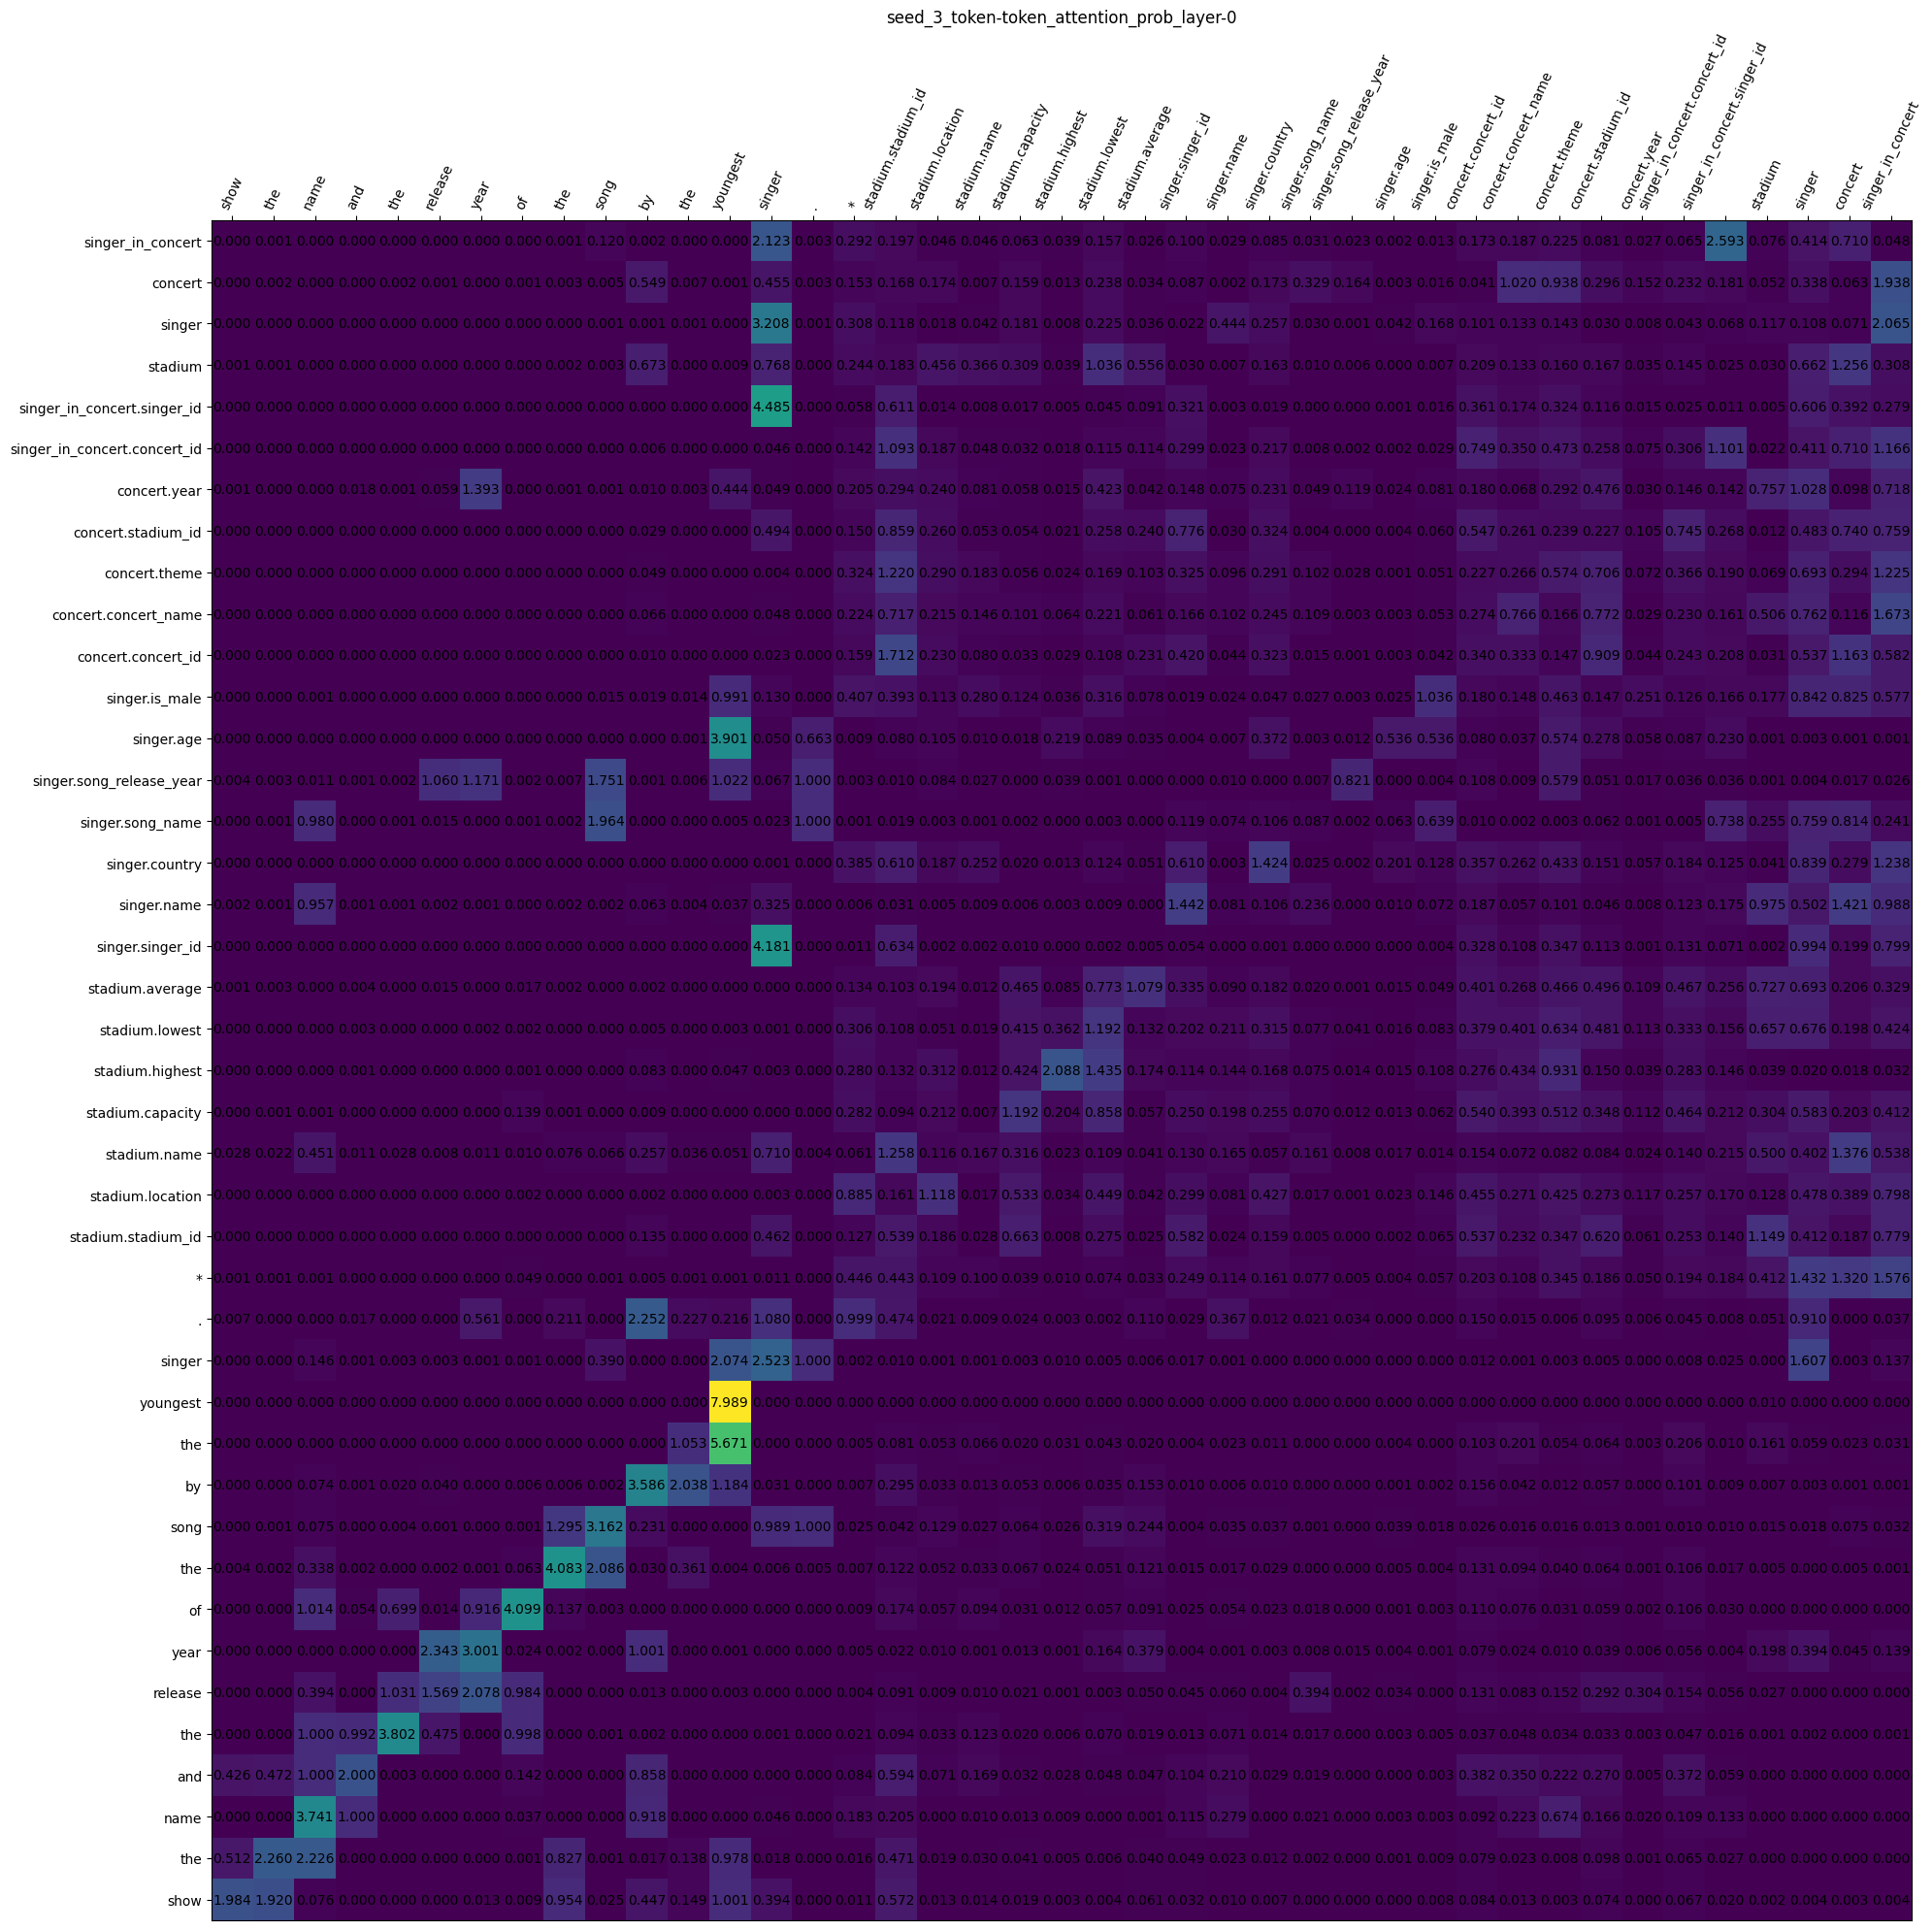

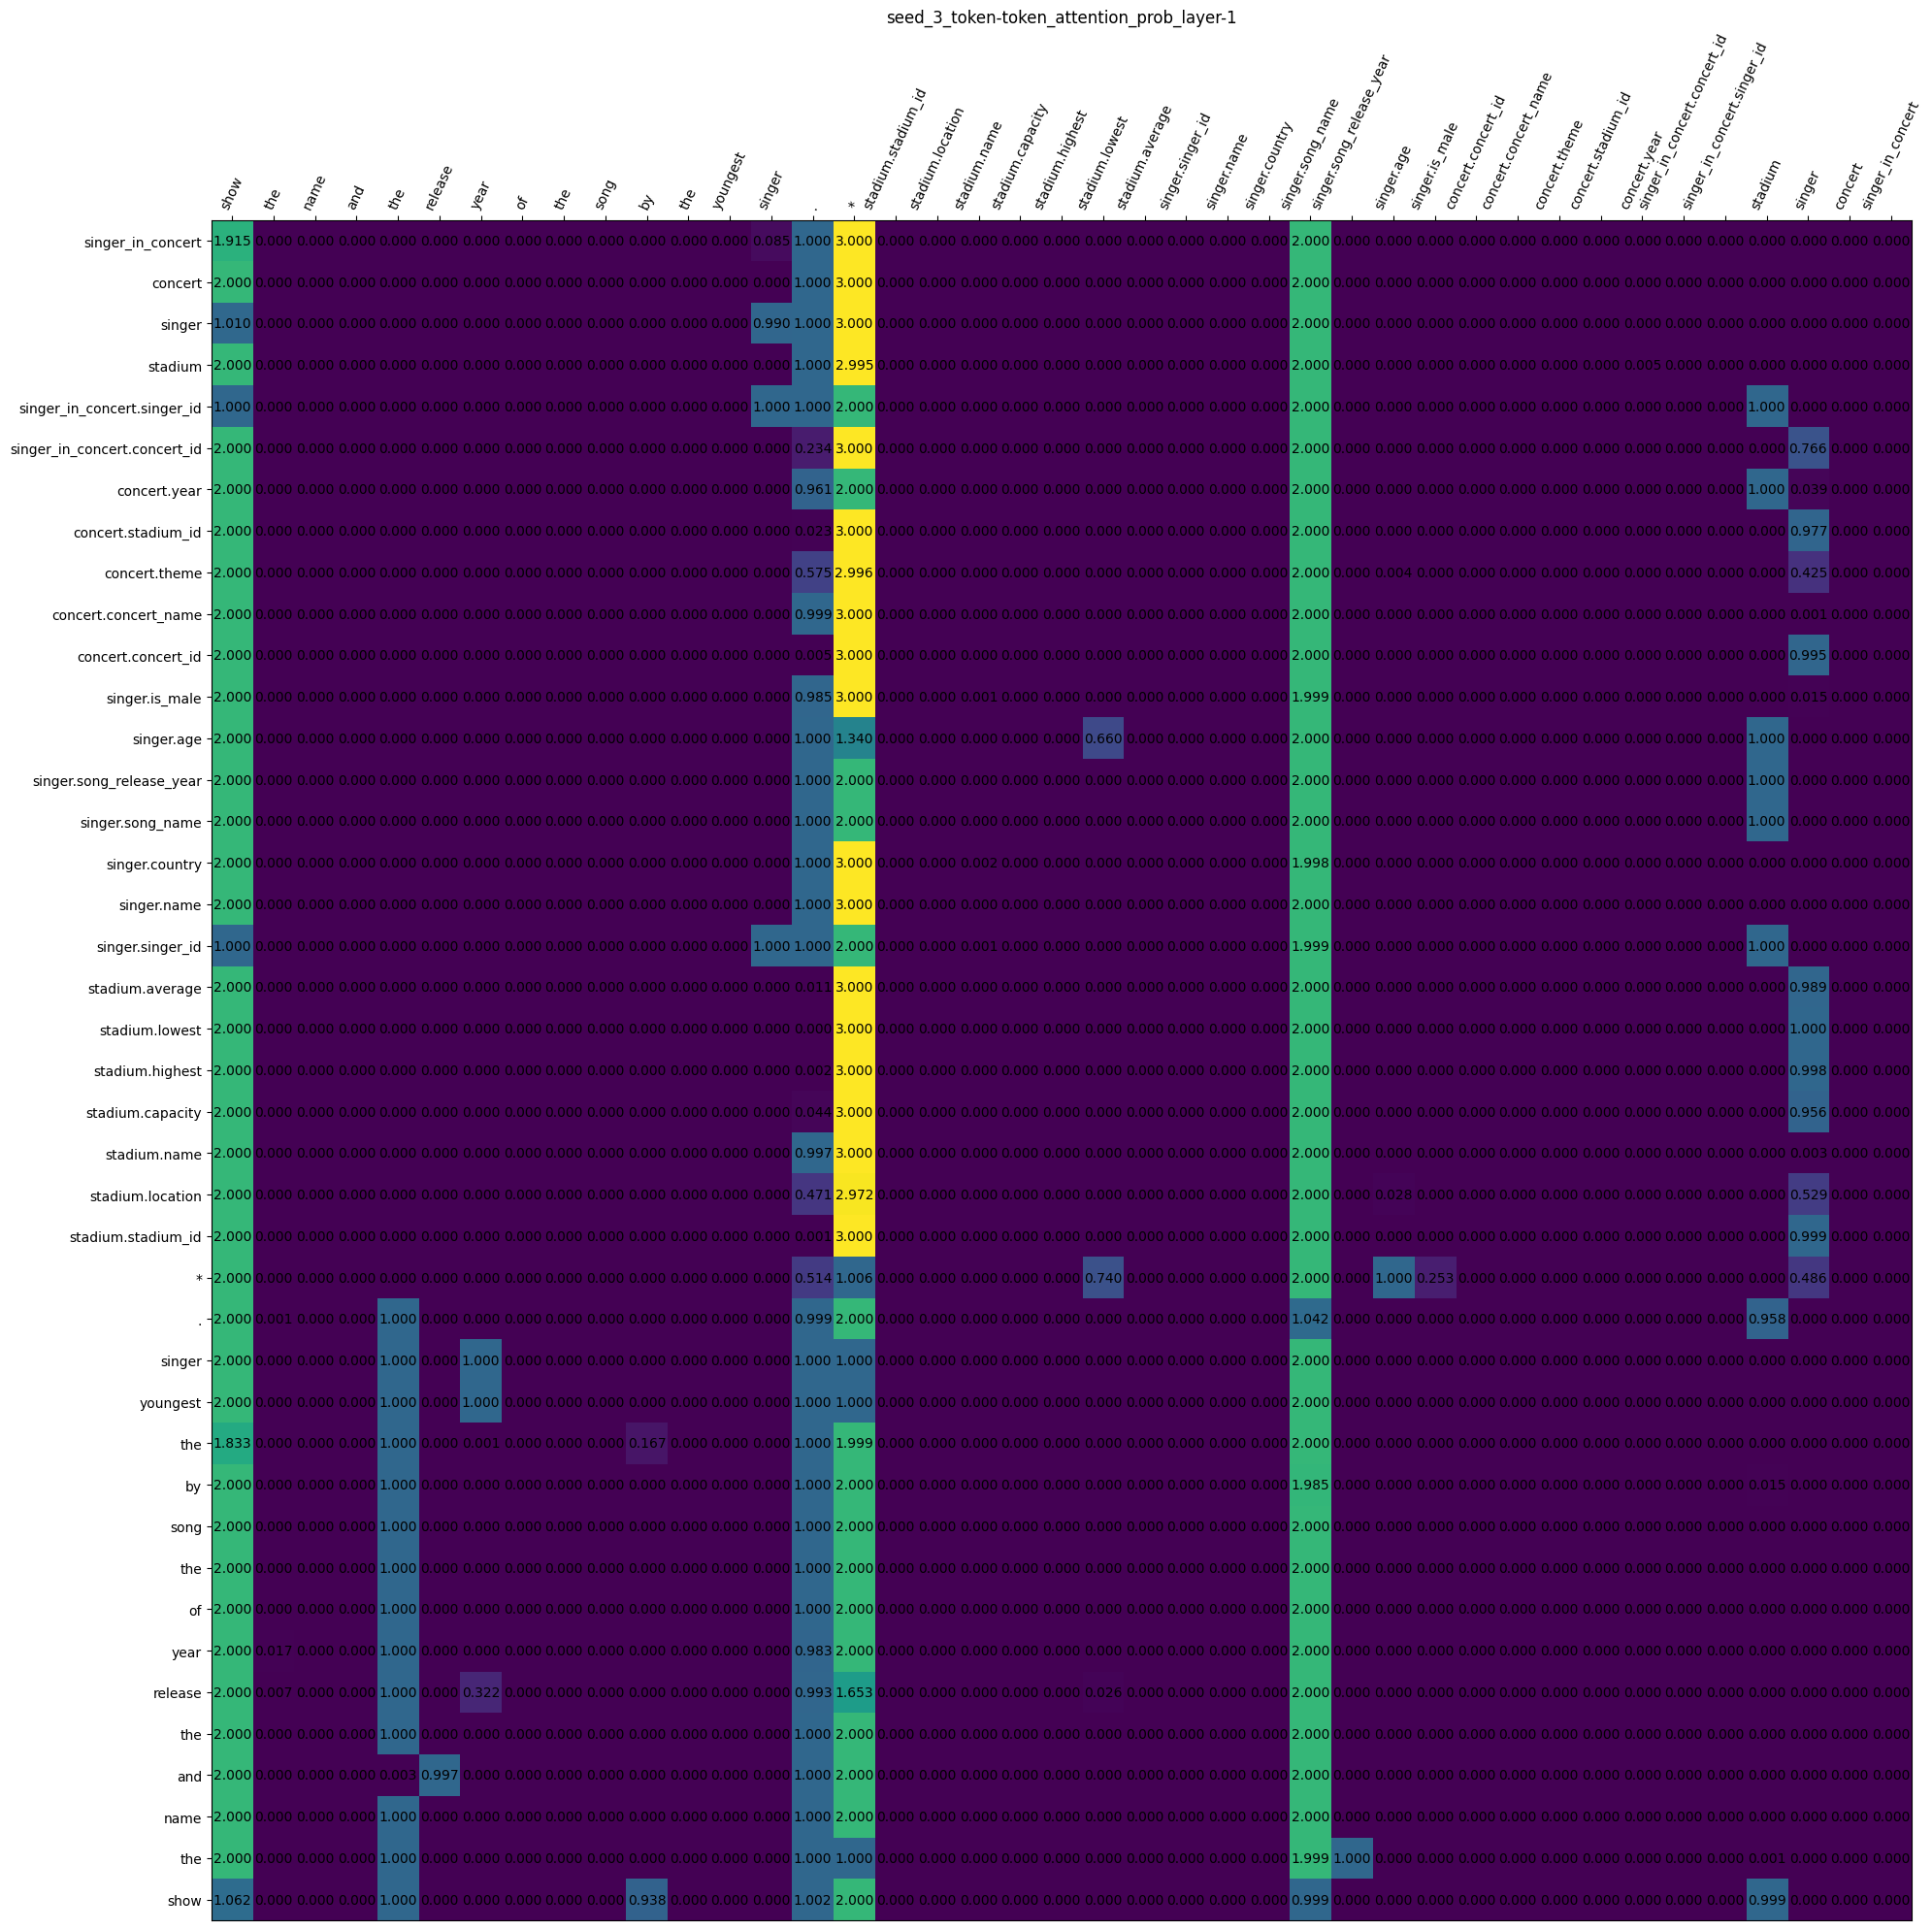

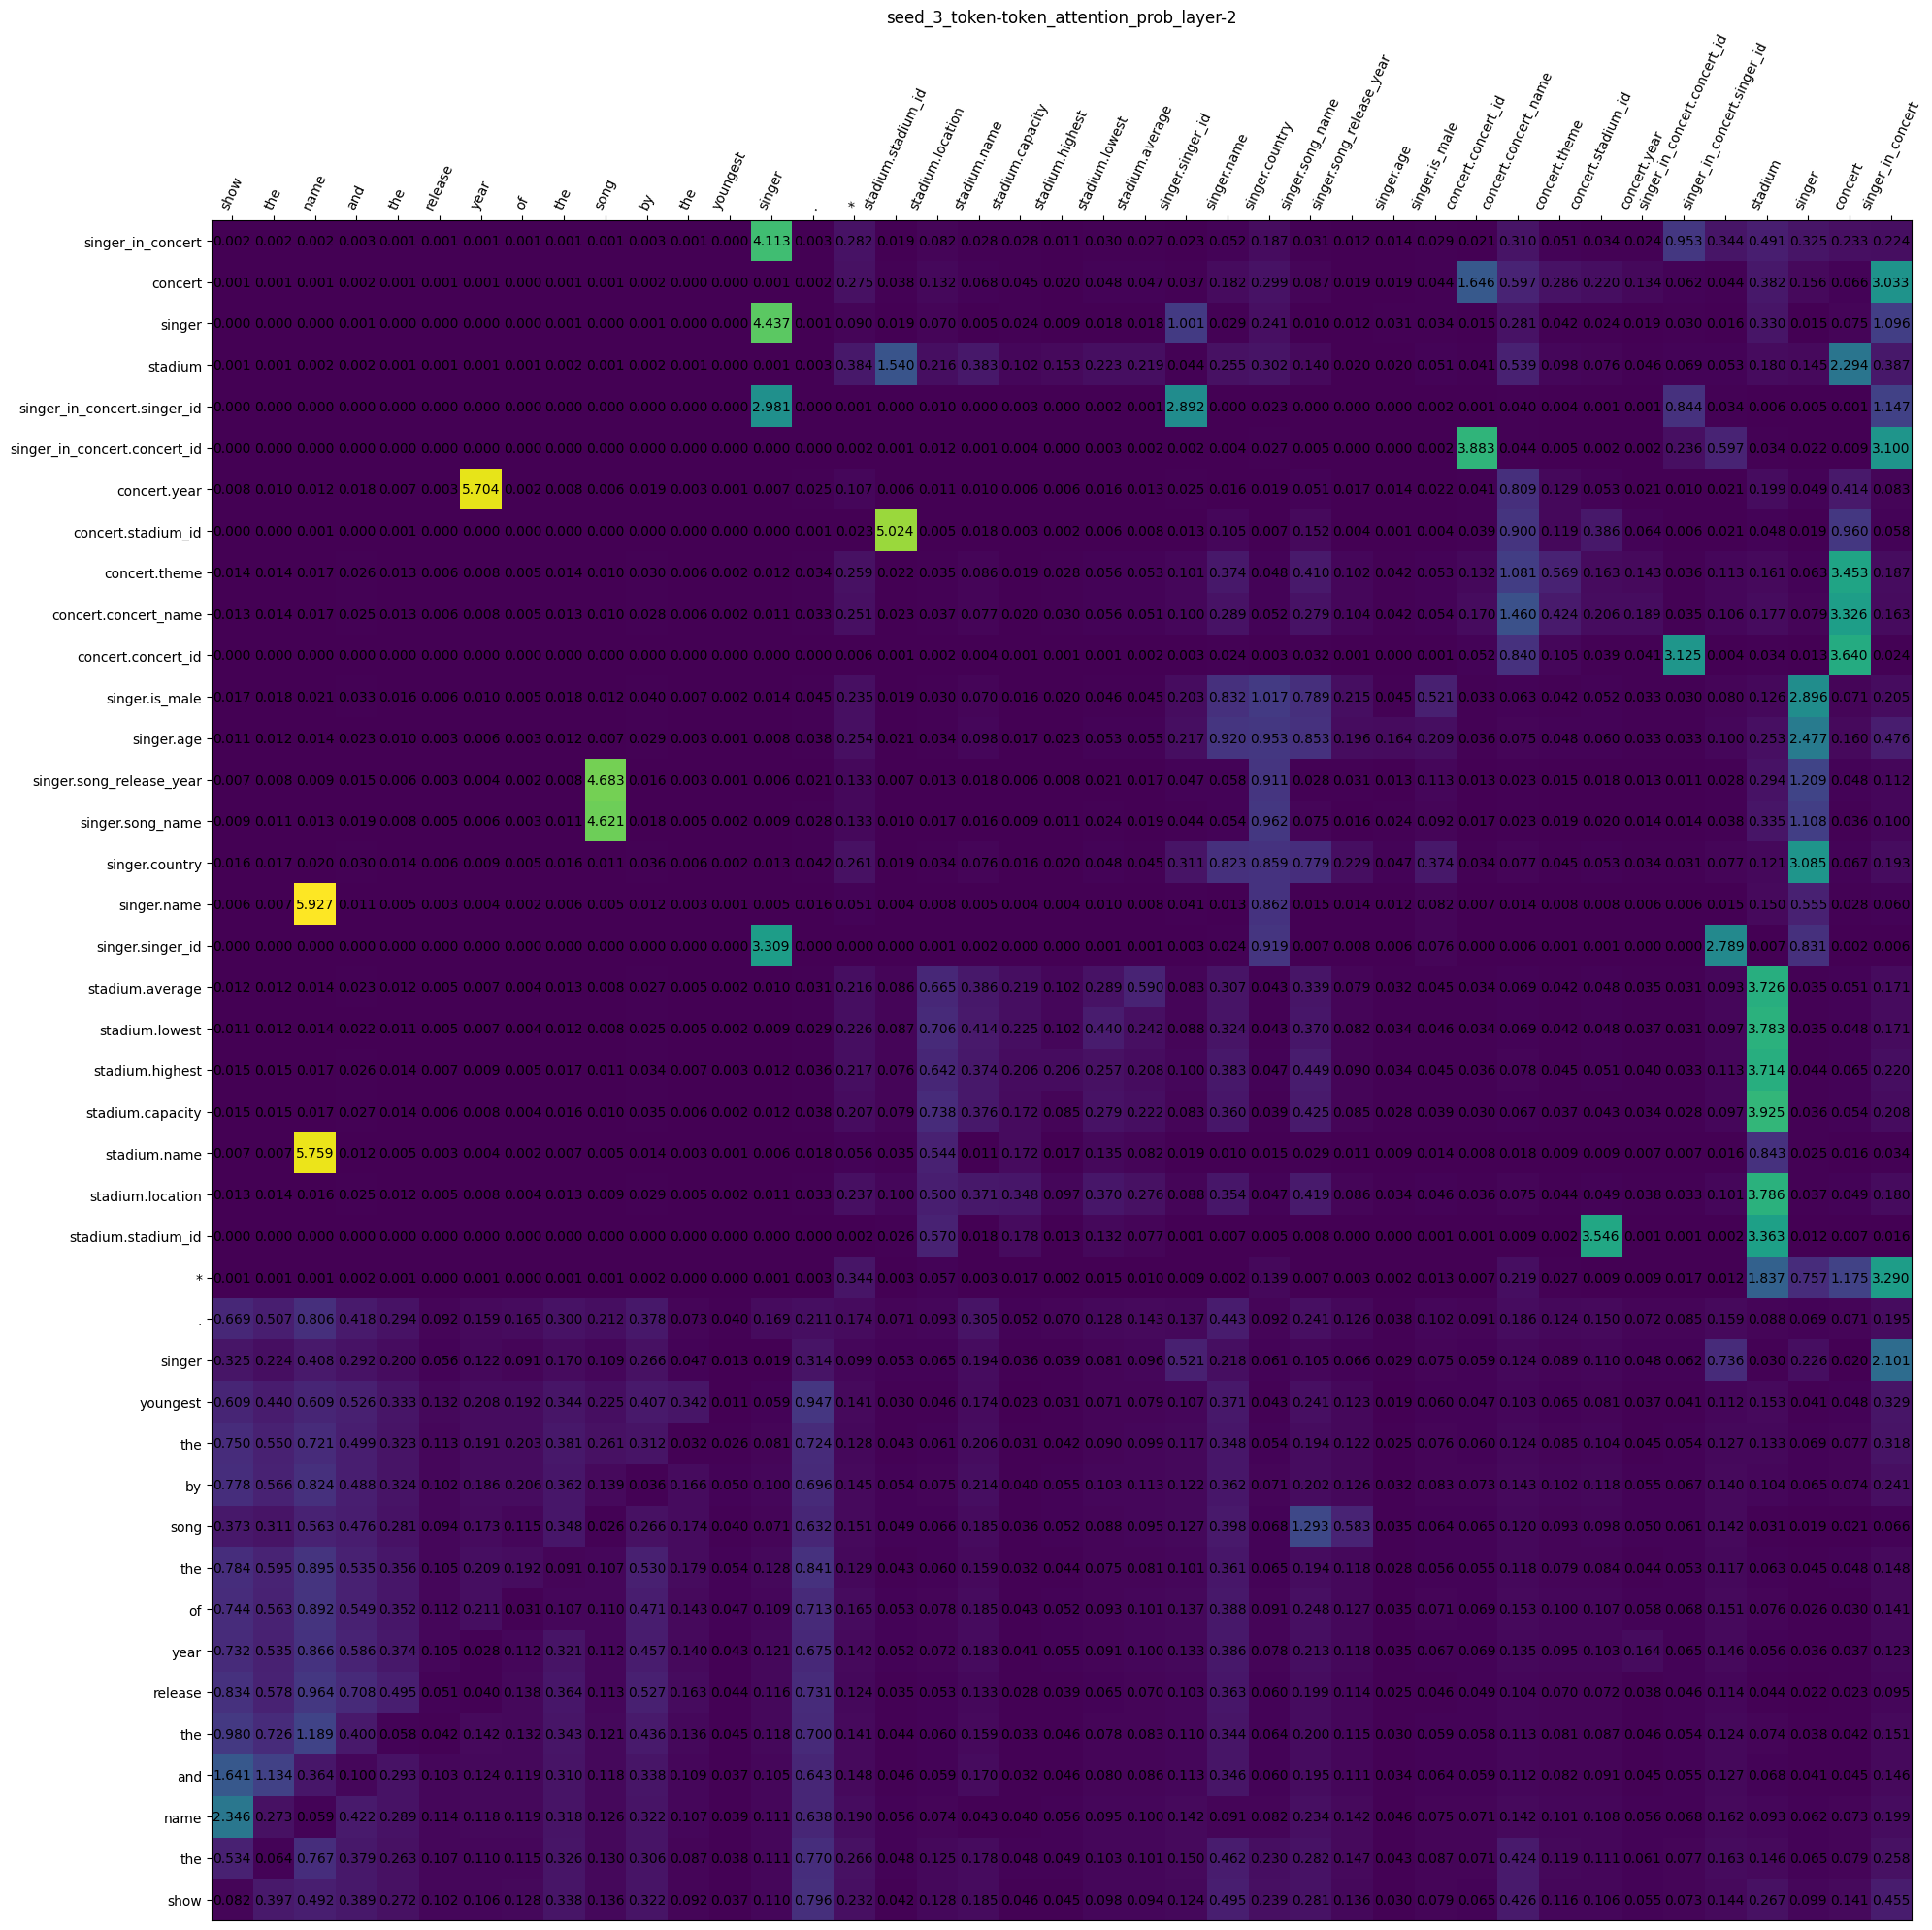

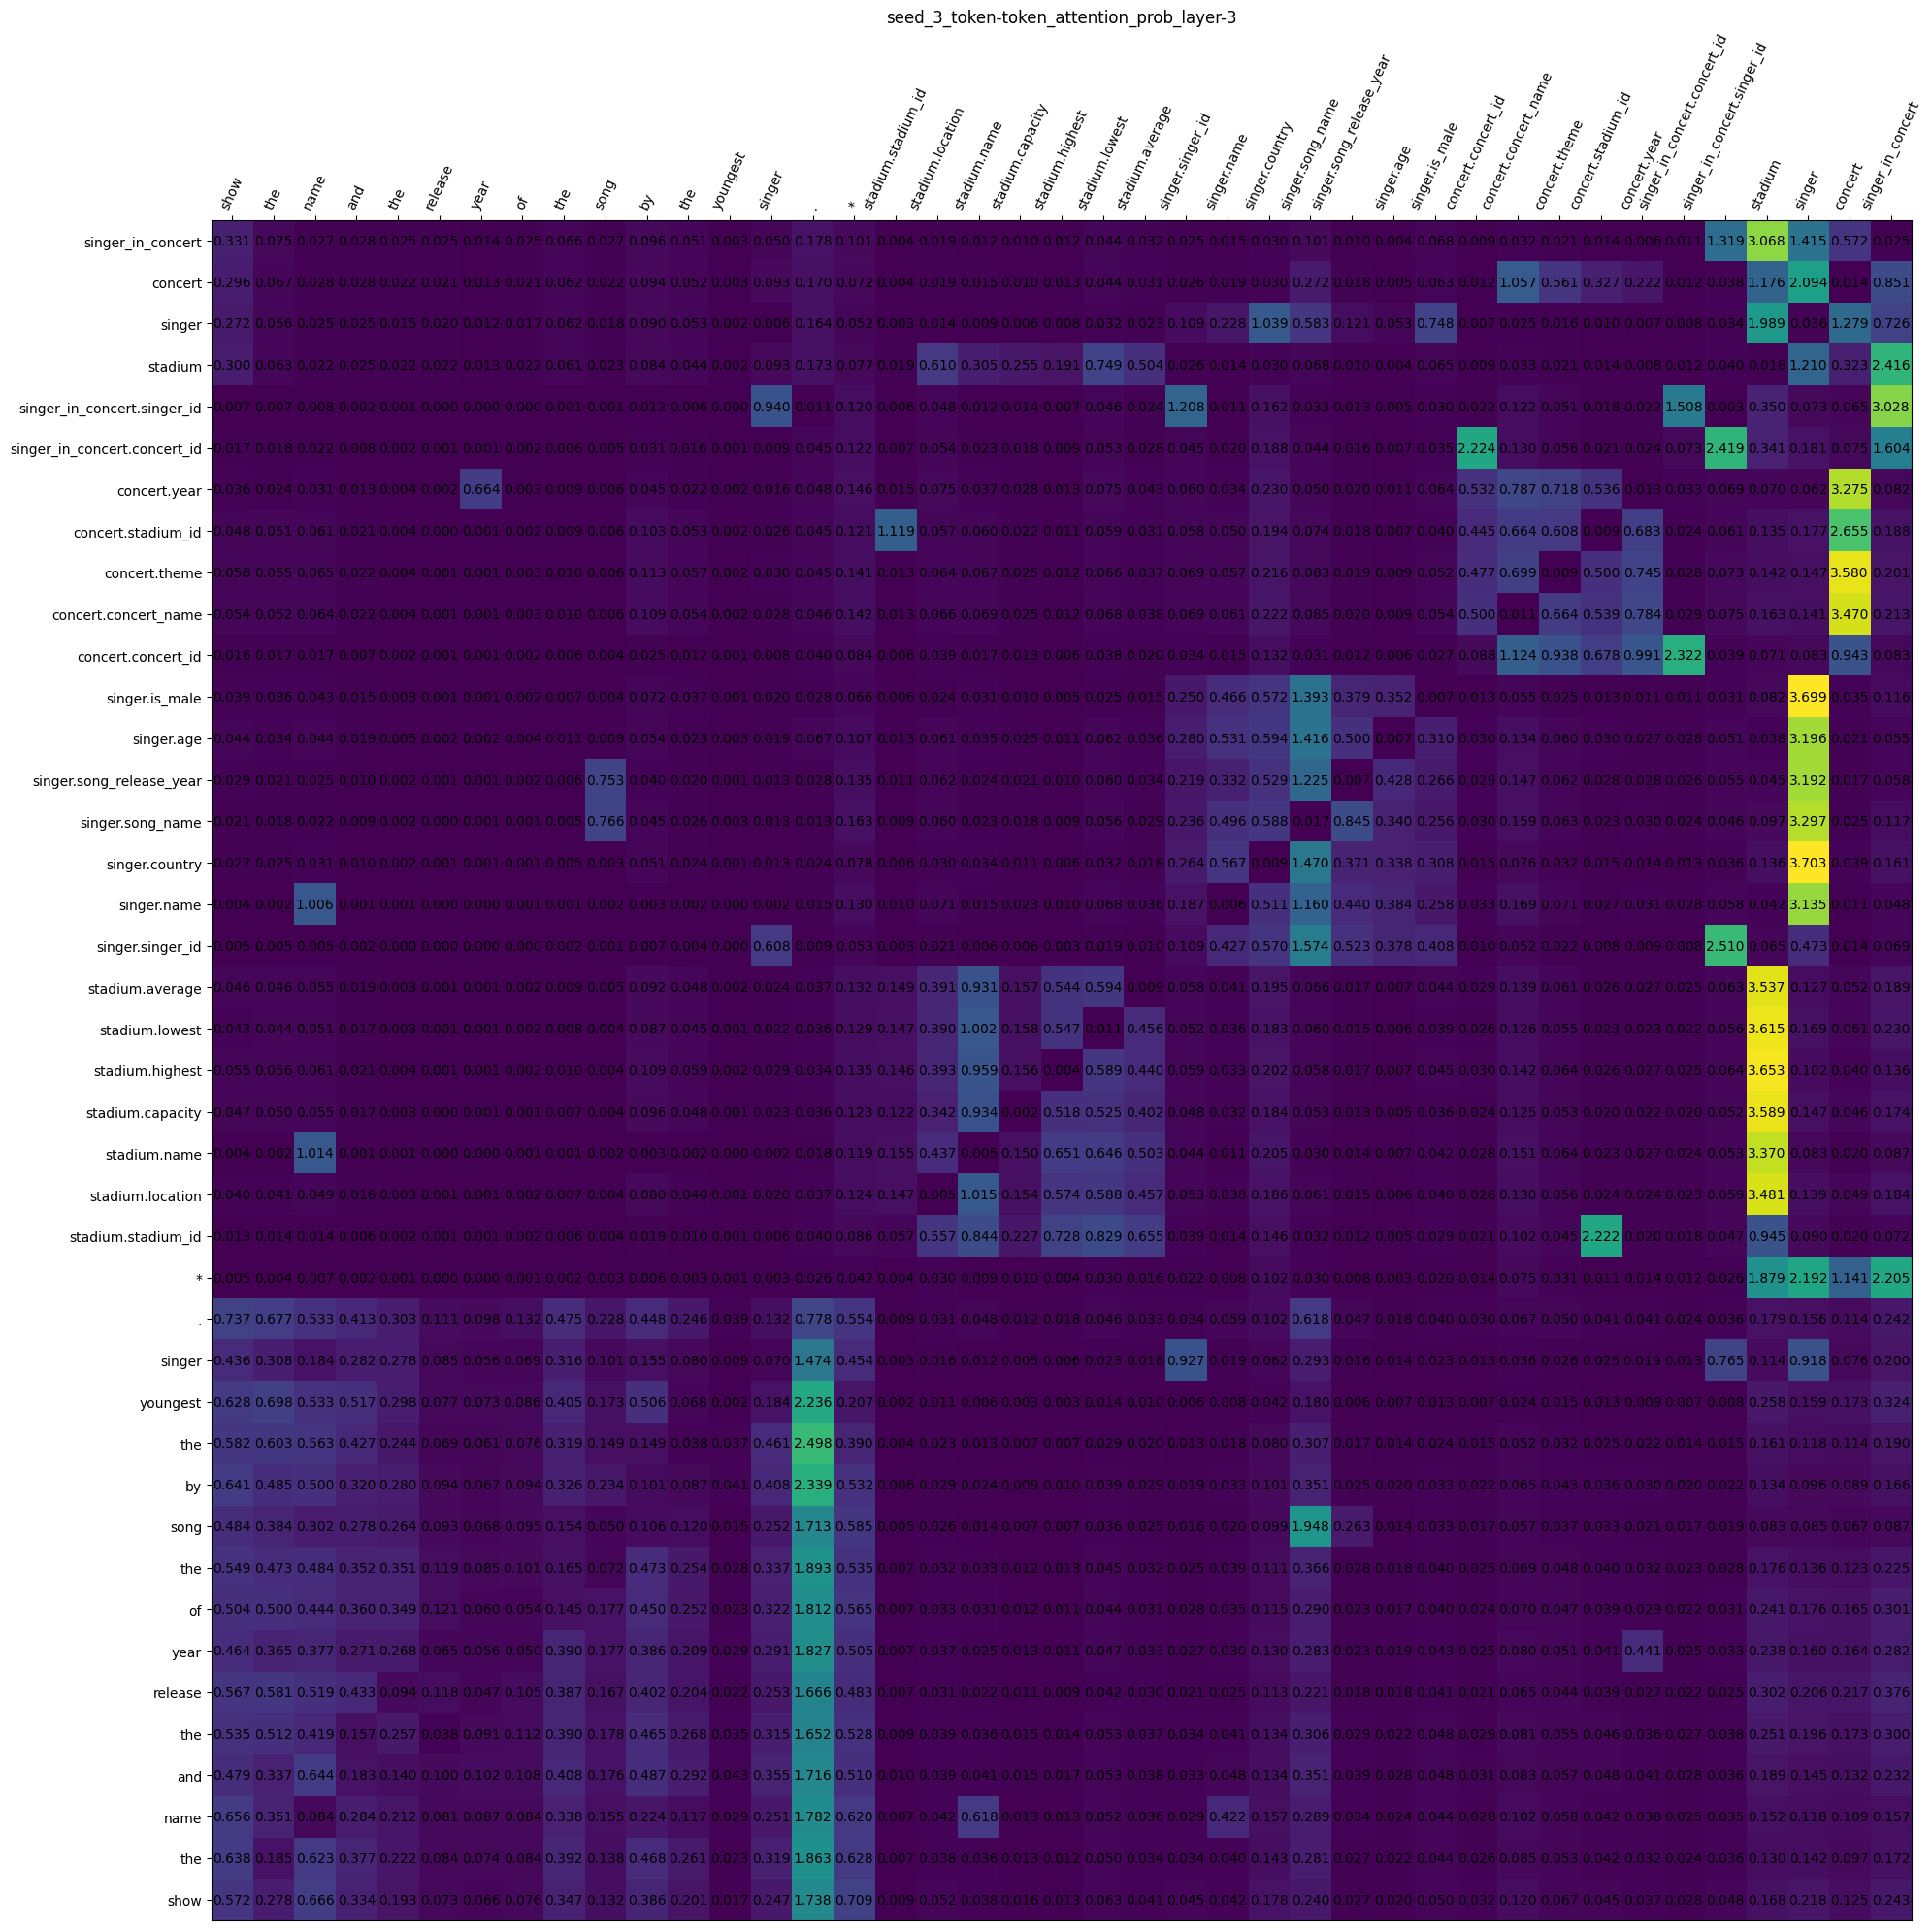

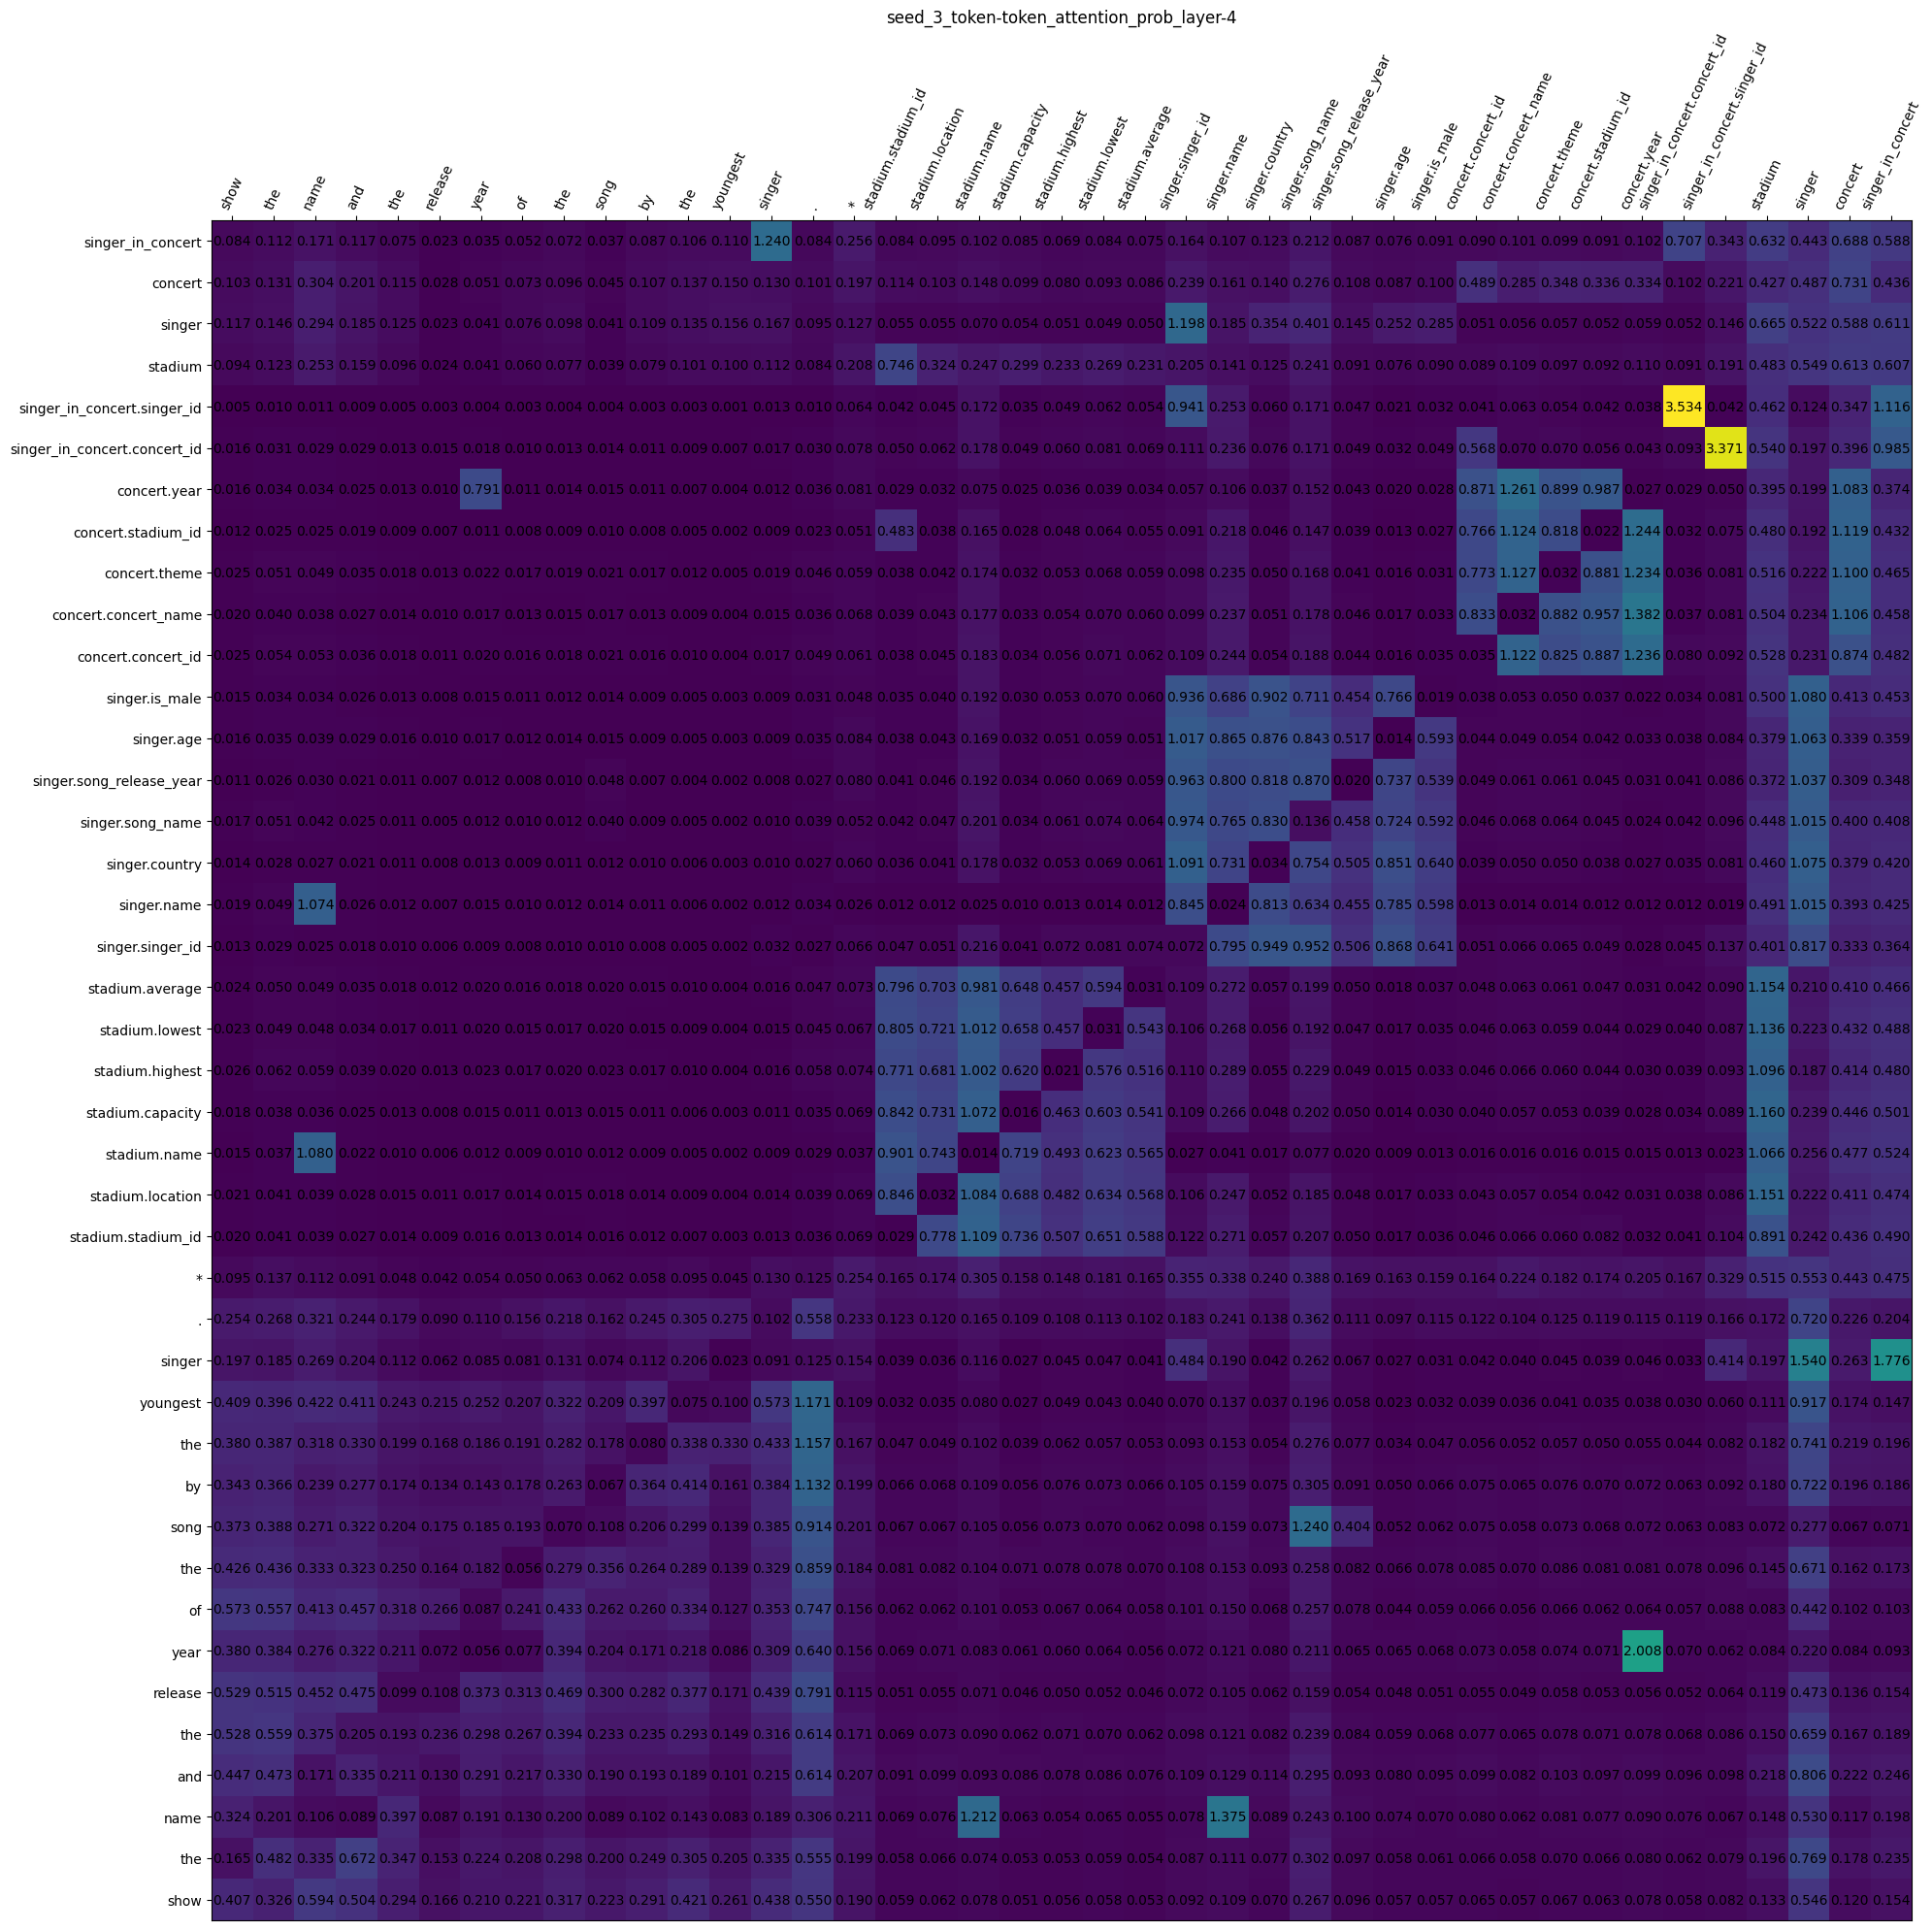

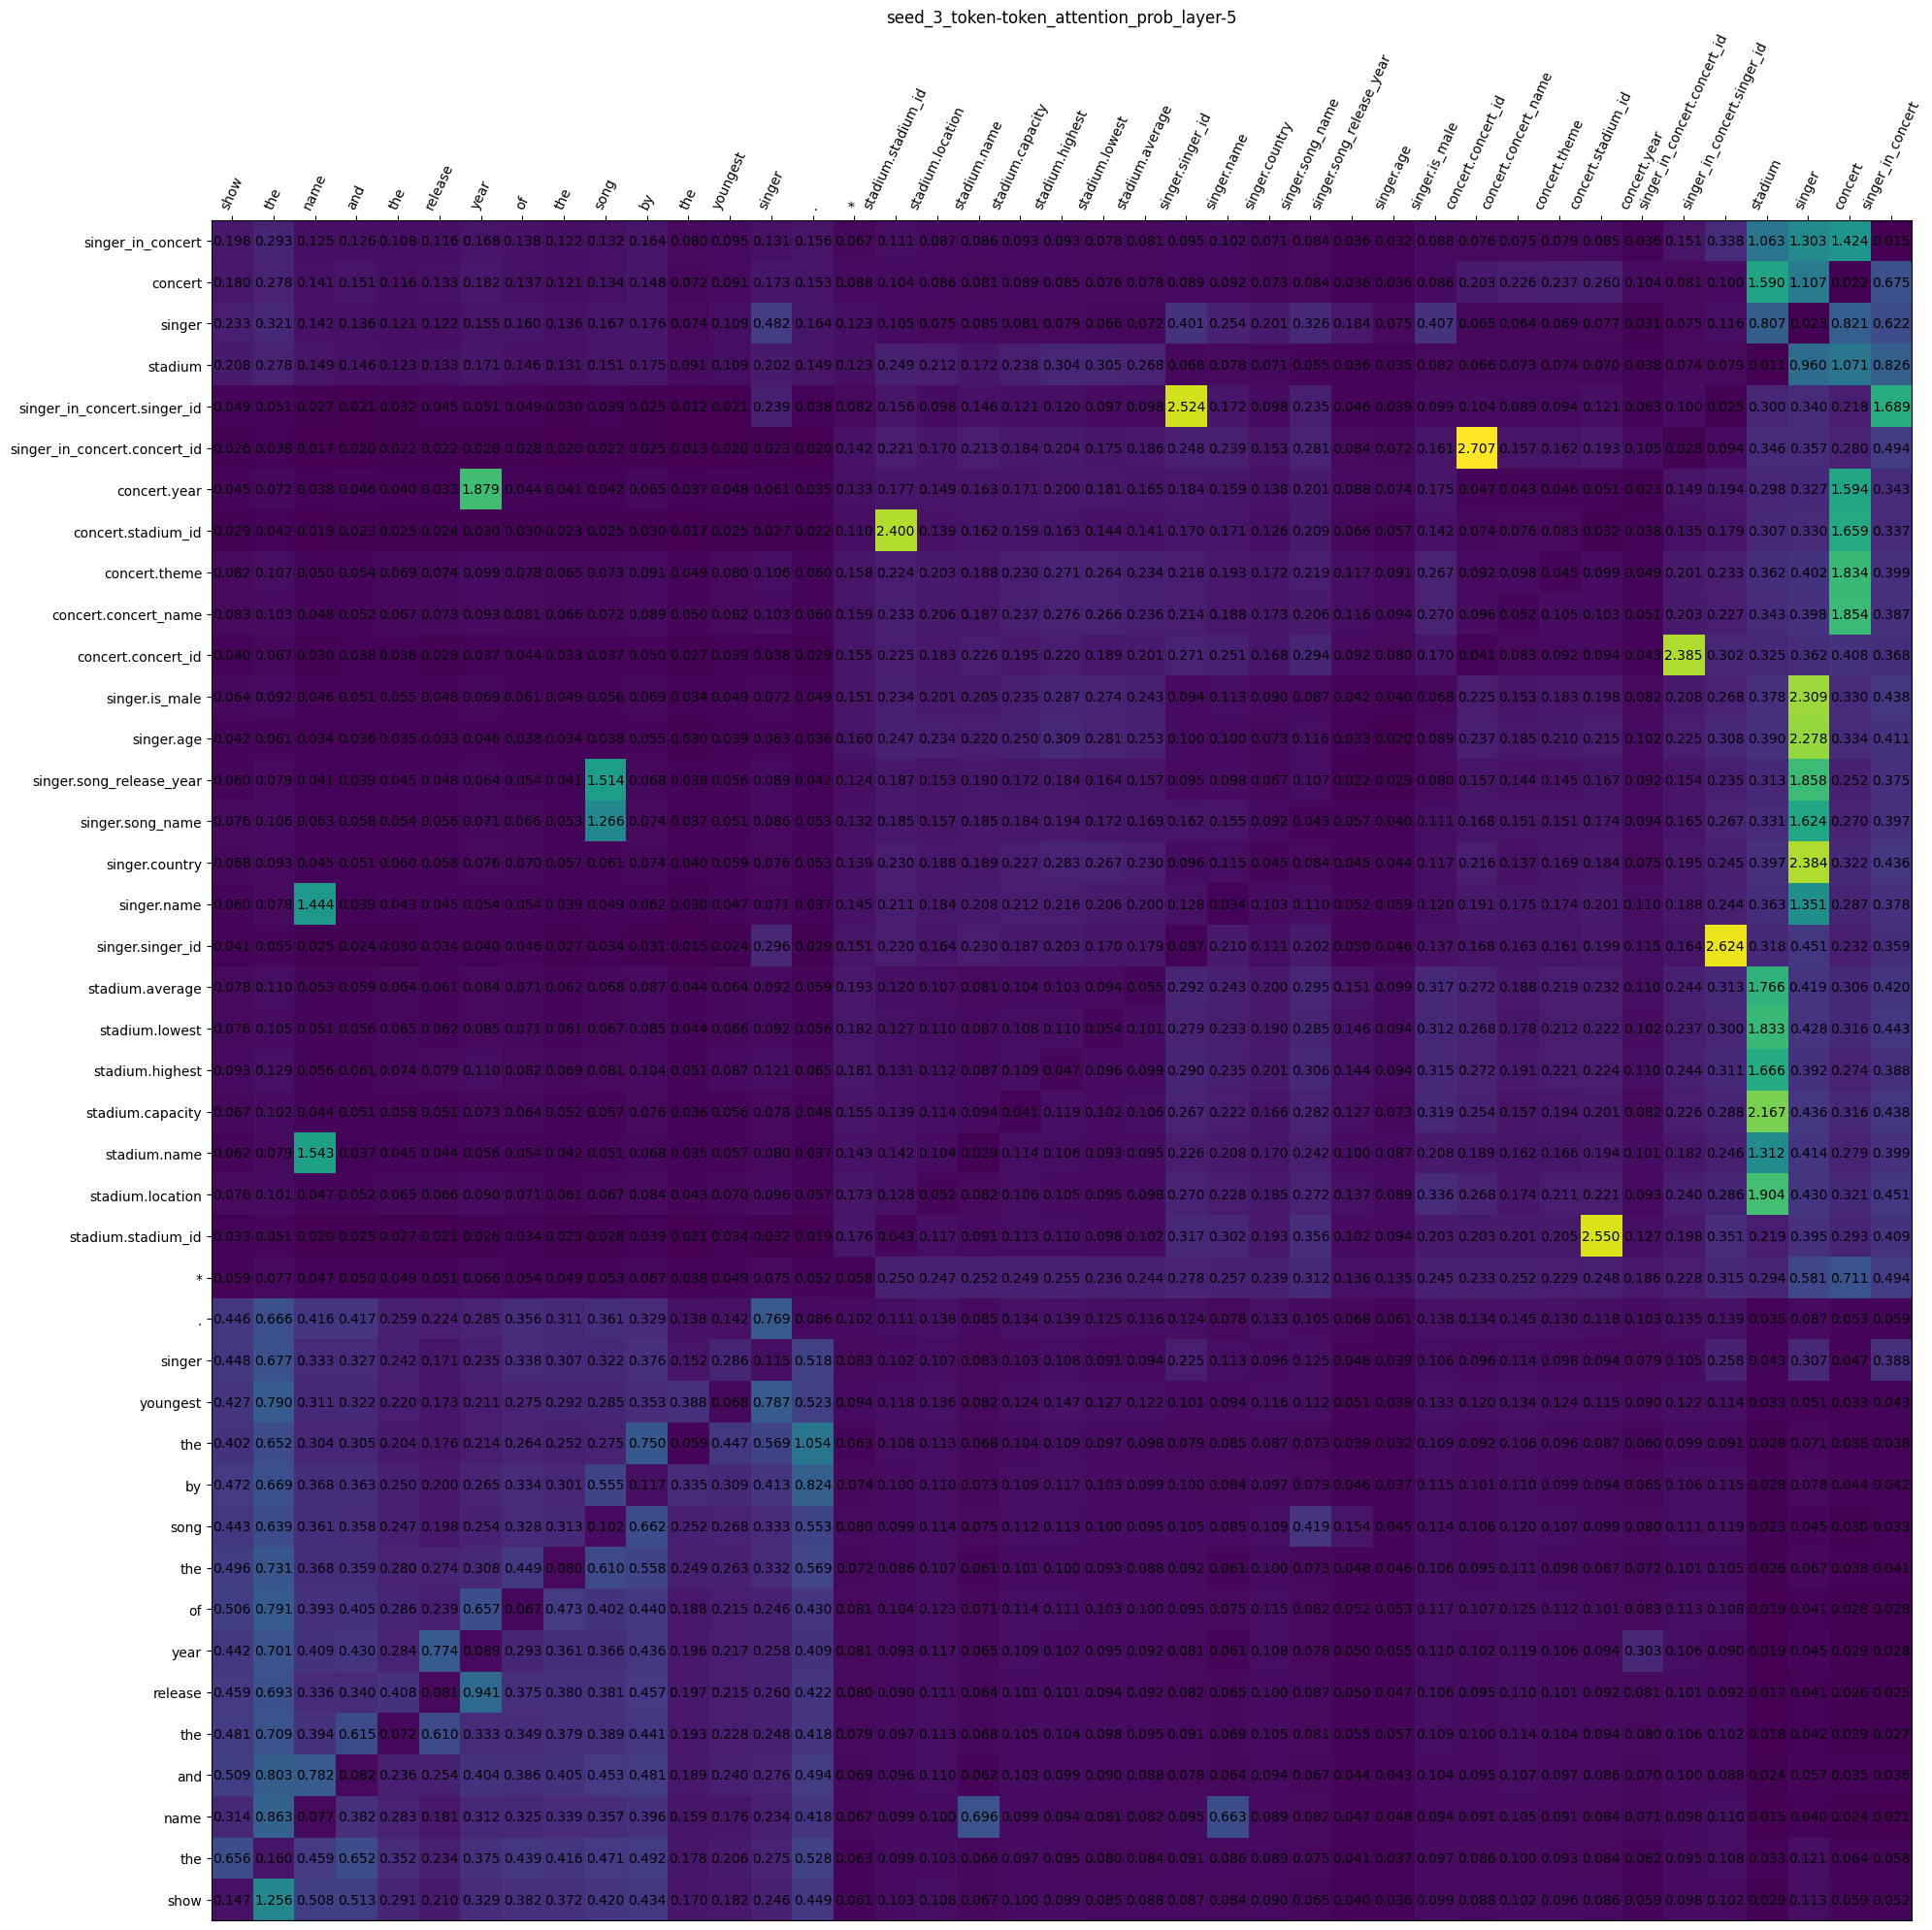

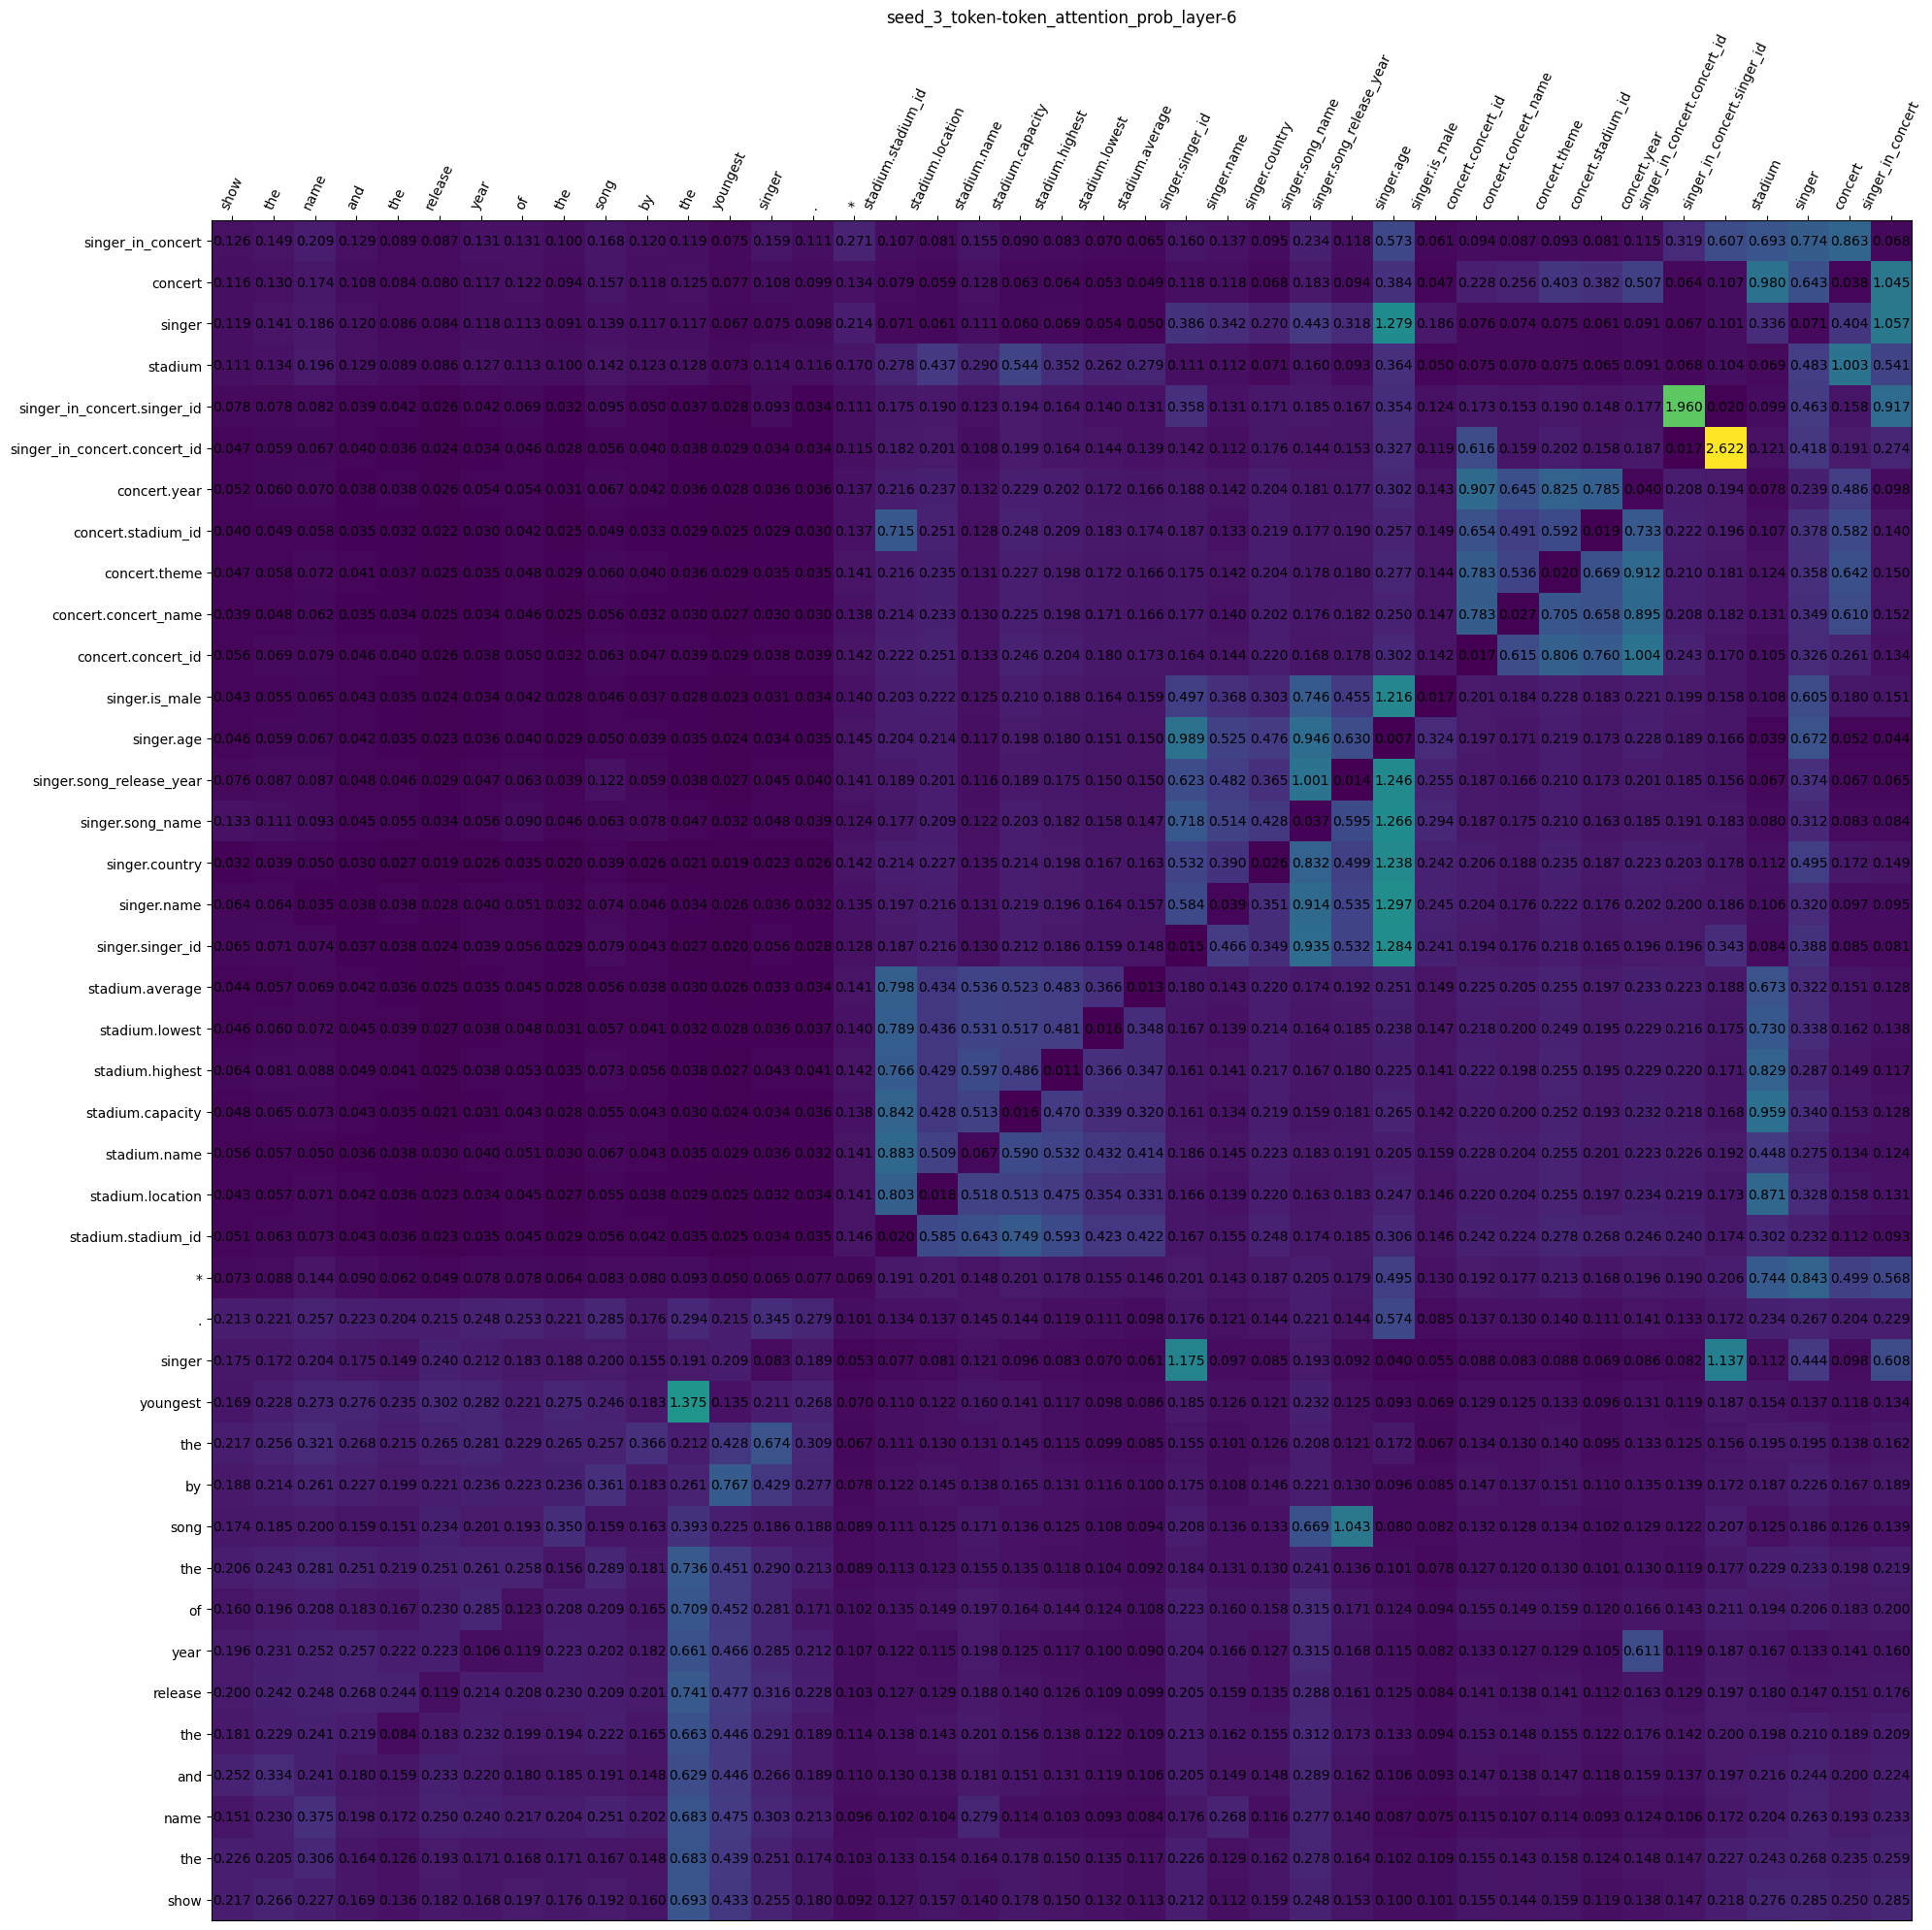

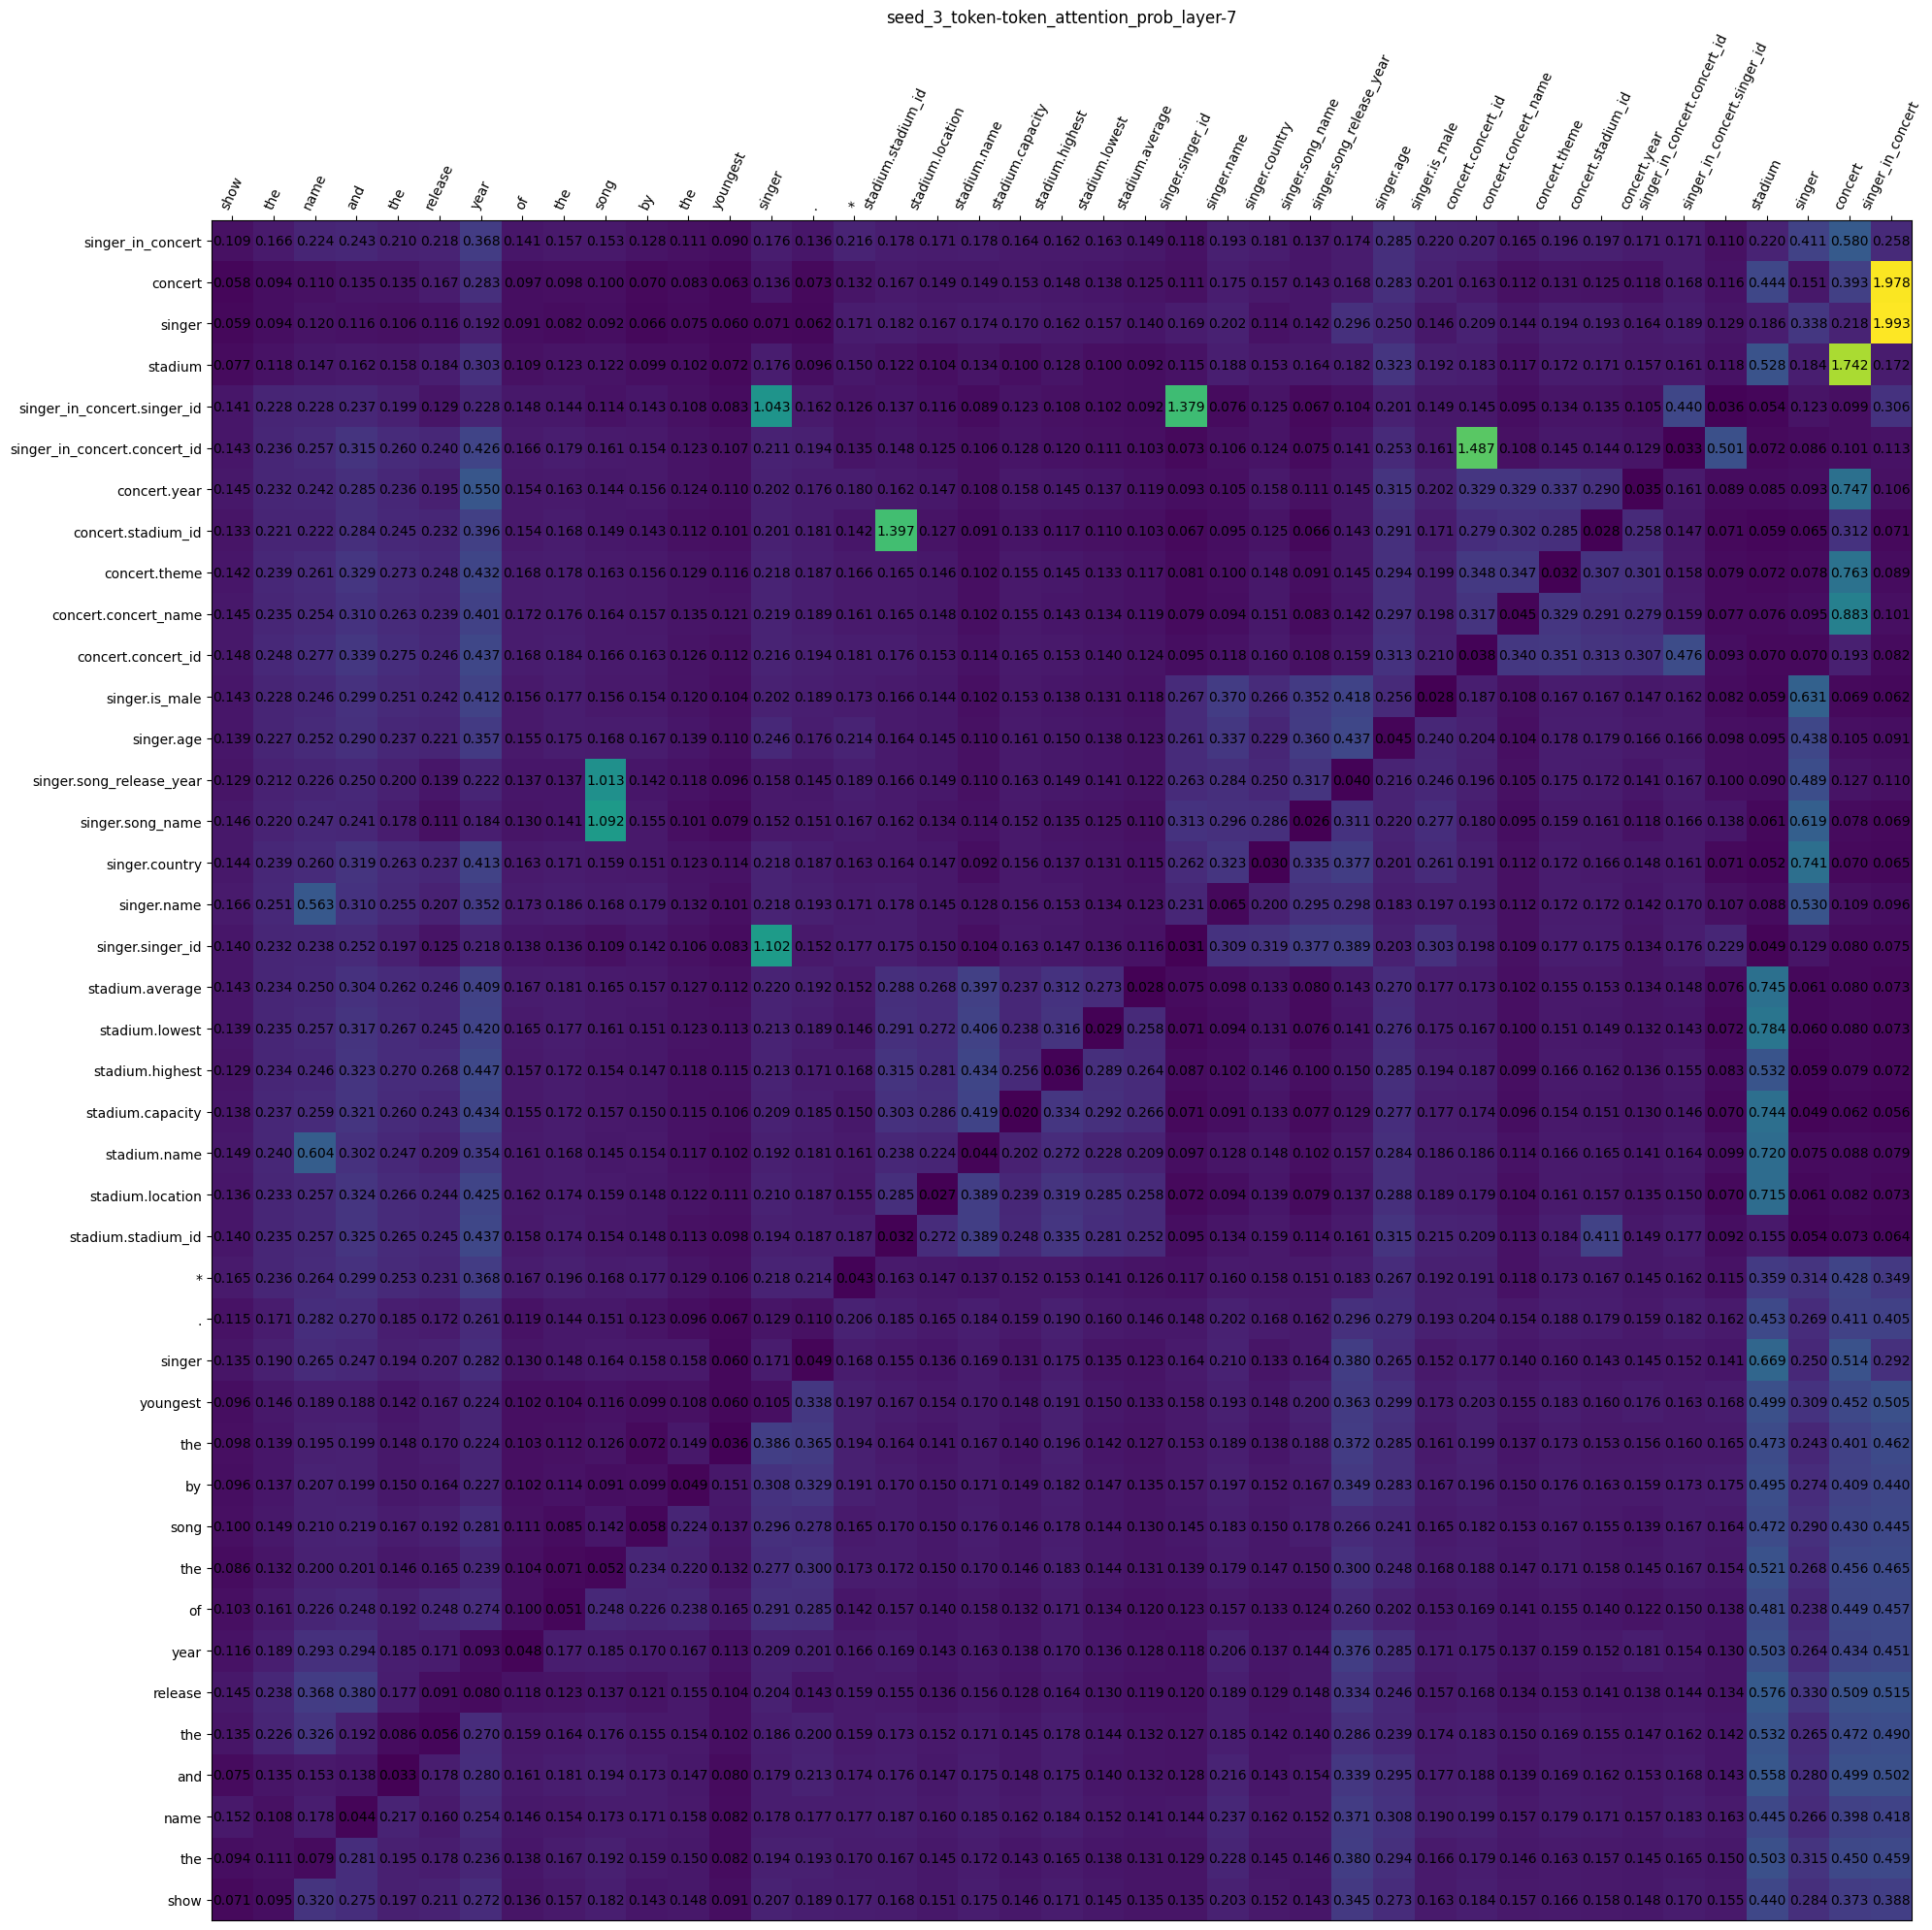

In [66]:
# Do analysis
show_encoder_details(eval_result, debug_result, debug_cache, infer_result, src_idx, des_idx, inspect_layer_num, target_key, top_k=None, prefix=f'seed_{target_seed}')

In [38]:
# show_basic_details(eval_result, debug_result, debug_cache, infer_result)
# db_id = eval_result['db_id']
# pred = eval_result['predicted']
# gold = eval_result['gold']
# decode_history = debug_result['history']
# correct = eval_result['exact']
# questions = debug_cache['question']
# input_columns = debug_cache['columns']
# input_tables = debug_cache['tables']
# columns = get_column_names(db_id)
# tables = get_table_names(db_id)
# assert len(columns) == len(input_columns), f"{len(columns)} vs {len(input_columns)}"
# assert len(tables) == len(input_tables), f"{len(tables)} vs {len(input_tables)}"
# tokens = questions + columns + tables
# tokens_len = len(tokens)
# bert_attention = torch.stack(debug_cache['bert_attention']).squeeze(1)
# bert_attention = bert_attention[:2]
# bert_tokens = debug_cache['input_tokens']
# flow_att_mat = get_attention_flow(bert_tokens, bert_attention)

In [39]:
# sentence = ' '.join(bert_tokens[1:-1])
# draw_attention_flow(sentence, 3, flow_att_mat, [10, 14])

In [40]:
# decoder_inspect_step_idx = 9
# show_decoder_details(eval_result, debug_result, debug_cache, infer_result, inspect_step_idx=decoder_inspect_step_idx)